# INIZIALIZZAZIONE

In [1]:
# importo le librerie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm

from IPython.display import display, Markdown

import requests
from bs4 import BeautifulSoup
import os 
from dotenv import load_dotenv 

import sqlite3

In [2]:
#carico il dataset
file_path=r"C:\Documenti\Lavoro\Progetti Data Analyst\archive\Train-Set.csv"
df=pd.read_csv(file_path)

In [3]:
#verifico il dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductID          8523 non-null   object 
 1   Weight             7060 non-null   float64
 2   FatContent         8523 non-null   object 
 3   ProductVisibility  8523 non-null   float64
 4   ProductType        8523 non-null   object 
 5   MRP                8523 non-null   float64
 6   OutletID           8523 non-null   object 
 7   EstablishmentYear  8523 non-null   int64  
 8   OutletSize         6113 non-null   object 
 9   LocationType       8523 non-null   object 
 10  OutletType         8523 non-null   object 
 11  OutletSales        8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df.shape

(8523, 12)

# DATA CLEANING

## Missing value "Weight"

In [6]:
#la colonna "weight" ha dei missing value che vanno gestiti
#verifico se esistono prodotti con più pesi diversi
df.groupby('ProductID')['Weight'].nunique().sort_values(ascending=False).head()

ProductID
NCZ54    1
DRA12    1
DRA24    1
DRA59    1
DRB01    1
Name: Weight, dtype: int64

In [7]:
# imputo i valori mancanti assumendo il peso come proprietà del prodotto
df['Weight'] = df.groupby('ProductID')['Weight'].transform(lambda x: x.fillna(x.median()))

In [8]:
df['Weight'].isna().sum()

np.int64(4)

In [9]:
#rimangono solo 4/8523 entry senza peso, assumo per loro il peso medio di categoria
df['Weight'] = df['Weight'].fillna(df.groupby('ProductType')['Weight'].transform('mean'))

In [10]:
df['Weight'].isna().sum()

np.int64(0)

## Missing Value "OutletSize"

In [11]:
# Filtra tra le righe gli OutletID unici con OutletSize nullo
unique_null_outlets = df[df['OutletSize'].isnull()]['OutletID'].unique()

print("OutletID unici con OutletSize nullo:")
print(unique_null_outlets)

OutletID unici con OutletSize nullo:
['OUT010' 'OUT045' 'OUT017']


In [12]:
# Conteggio dei valori per categoria di OutletSize
outletsize_counts = df['OutletSize'].value_counts(dropna=False)  # dropna=False include i NaN
print("Conteggio degli OutletSize per categoria:")
print(outletsize_counts)

Conteggio degli OutletSize per categoria:
OutletSize
Medium    2793
NaN       2410
Small     2388
High       932
Name: count, dtype: int64


In [13]:
# Conteggio degli outlet unici per categoria di OutletSize
outlet_per_size = df.groupby('OutletSize')['OutletID'].nunique()

print("Numero di OutletID unici per categoria di OutletSize:")
print(outlet_per_size)

Numero di OutletID unici per categoria di OutletSize:
OutletSize
High      1
Medium    3
Small     3
Name: OutletID, dtype: int64


In [14]:
# Conteggio delle righe per ciascun OutletID
rows_per_outlet = df['OutletID'].value_counts()

print("Numero di righe per ciascun OutletID:")
print(rows_per_outlet)

Numero di righe per ciascun OutletID:
OutletID
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64


In [15]:
#non ho un ragionamento forte dietro questa decisione ma per motivi di analisi assegno due outletID tra i NaN alla categoria Small e uno a Medium
# Assegna la categoria 'Small' a OUT010 e OUT017
df.loc[df['OutletID'].isin(['OUT010', 'OUT017']), 'OutletSize'] = 'Small'

# Assegna la categoria 'Medium' a OUT045
df.loc[df['OutletID'] == 'OUT045', 'OutletSize'] = 'Medium'

# Verifica il risultato
outlet_per_size = df.groupby('OutletSize')['OutletID'].nunique()
print(outlet_per_size)

OutletSize
High      1
Medium    4
Small     5
Name: OutletID, dtype: int64


## Categorizzazione "FatContent"

In [16]:
df["FatContent"].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [17]:
# aggrego 'Low Fat', 'low fat', 'LF' in una categoria e 'Regular' e 'reg' in un'altra
fat_mapping = {
    'Low Fat': 'Low Fat',
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'Regular': 'Regular',
    'reg': 'Regular'}

# Applica la mappatura alla colonna FatContent
df['FatContent'] = df['FatContent'].replace(fat_mapping)

# Verifica il risultato
print(df['FatContent'].value_counts())

FatContent
Low Fat    5517
Regular    3006
Name: count, dtype: int64


## Approccio alla "ProductVisibility"=0

<Axes: >

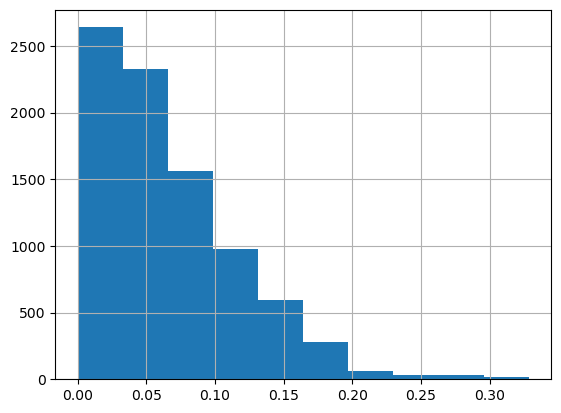

In [18]:
# ricerca di un metodo per gestire i prodotti con visibilità pari a 0
df["ProductVisibility"].hist()

In [19]:
# Filtro le righe con visibilità 0
zero_vis_rows = df[df['ProductVisibility'] == 0]

# Conto quanti ProductID unici ci sono in queste righe
unique_zeros = zero_vis_rows['ProductID'].nunique()

print(f"Righe totali con 0: {len(zero_vis_rows)}")      
print(f"Prodotti unici con 0: {unique_zeros}")           

Righe totali con 0: 526
Prodotti unici con 0: 446


In [20]:
# verifico la correlazione tra le colonne numeriche
# in caso di forte correlazione posso assumere una dipendenza 
# ed avere delle basi per assegnare dei valori ai prodotti con visibilià 0
numerical_columns = ['Weight', 'ProductVisibility', 'MRP', 'EstablishmentYear', 'OutletSales']
correlation_matrix = df[numerical_columns].corr()
print(correlation_matrix)

                     Weight  ProductVisibility       MRP  EstablishmentYear  \
Weight             1.000000          -0.009215  0.025967          -0.013417   
ProductVisibility -0.009215           1.000000 -0.001315          -0.074834   
MRP                0.025967          -0.001315  1.000000           0.005020   
EstablishmentYear -0.013417          -0.074834  0.005020           1.000000   
OutletSales        0.013198          -0.128625  0.567574          -0.049135   

                   OutletSales  
Weight                0.013198  
ProductVisibility    -0.128625  
MRP                   0.567574  
EstablishmentYear    -0.049135  
OutletSales           1.000000  


In [21]:
# non trovo correlazioni forti tra le colonne numeriche

In [22]:
# Creiamo una colonna booleana per identificare i valori di visibilità zero
df['VisibilityZero'] = df['ProductVisibility'] == 0

# Calcoliamo la percentuale di prodotti con visibilità zero per ogni categoria
visibility_zero_by_category = df.groupby('ProductType')['VisibilityZero'].mean() * 100
visibility_zero_by_category = visibility_zero_by_category.sort_values(ascending=False)
print(visibility_zero_by_category)

ProductType
Starchy Foods            10.135135
Hard Drinks               7.943925
Soft Drinks               7.640449
Fruits and Vegetables     7.061688
Baking Goods              6.944444
Breads                    6.772908
Health and Hygiene        6.346154
Seafood                   6.250000
Frozen Foods              5.957944
Others                    5.917160
Snack Foods               5.666667
Household                 5.604396
Dairy                     5.571848
Canned                    5.084746
Meat                      4.705882
Breakfast                 2.727273
Name: VisibilityZero, dtype: float64


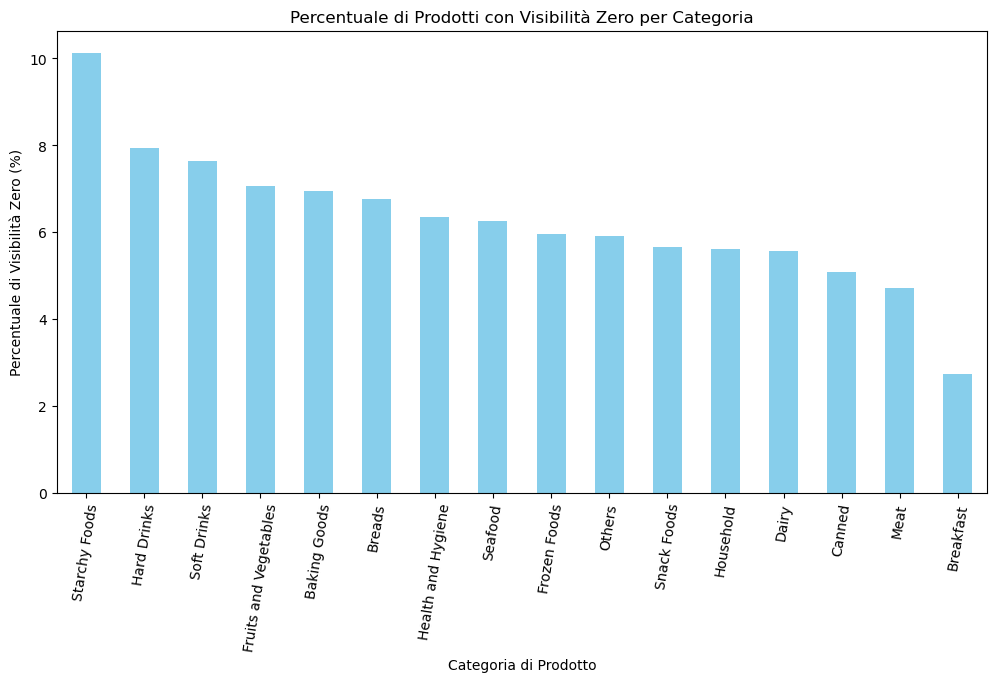

In [23]:
visibility_zero_by_category.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Percentuale di Prodotti con Visibilità Zero per Categoria')
plt.xlabel('Categoria di Prodotto')
plt.ylabel('Percentuale di Visibilità Zero (%)')
plt.xticks(rotation=81)
plt.show()

In [24]:
#faccio la stessa analisi fatta per le categorie ma per i prodotti
products_visibility_zero = df[df['ProductVisibility'] == 0]
product_zero_counts = products_visibility_zero['ProductID'].value_counts()
print(product_zero_counts)

ProductID
FDY07    4
NCD19    3
NCQ05    3
NCK54    3
FDY55    3
        ..
FDA39    1
FDR44    1
NCZ54    1
FDL58    1
FDR47    1
Name: count, Length: 446, dtype: int64


In [25]:
filtered_product_zero_counts = product_zero_counts[product_zero_counts >= 3]
print(filtered_product_zero_counts)

ProductID
FDY07    4
NCD19    3
NCQ05    3
NCK54    3
FDY55    3
FDH48    3
NCK29    3
Name: count, dtype: int64


In [26]:
#questi prodotti appartengono a diverse categorie e non è sistematica la loro esclusione dalla vetrina 
#pertanto assumiamo che i prodotti con visibilità 0 siano tenuti in magazzino e non ne modifichiamo il valore

## Ricerca duplicati, errori nei dati e creazione di nuove feature

In [27]:
#ricerca di duplicati
df.duplicated().sum()

np.int64(0)

In [28]:
#CREAZIONE DI FEATURE UTILI PER L'ANALISI

#fasce di prezzo
df['PriceBand'] = pd.qcut(df['MRP'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

# EUS (EstimatedUnitsSold), proxy di volume basata su fatturato e prezzo di listino
df["EstimatedUnitsSold"]=(df["OutletSales"]/df["MRP"]).round(2)

#età del punto vendita
df['OutletAge'] = 2025 - df['EstablishmentYear']

In [29]:
# OutletSales è una misura di fatturato in unità monetarie non specificate 
# L’analisi si concentra su confronti relativi e pattern interni

In [30]:
#arrotondo i valori di prezzo di vendita e ricavo di periodo alla seconda cifra decimale, in linea con le pratiche finance
df['MRP'] = df['MRP'].round(2)
df['OutletSales'] = df['OutletSales'].round(2)

In [31]:
df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales,VisibilityZero,PriceBand,EstimatedUnitsSold,OutletAge
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14,False,High,14.95,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42,False,Low,9.19,16
2,FDN15,17.50,Low Fat,0.016760,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27,False,Mid-Low,14.81,26
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.10,OUT010,1998,Small,Tier 3,Grocery Store,732.38,True,Mid-High,4.02,27
4,NCD19,8.93,Low Fat,0.000000,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71,True,Low,18.47,38


In [32]:
# definisco un range per gli MRP di prodotto tra diversi store, alla ricerca di eventuali errori nel dato
mrp_stats = (df.groupby('ProductID')['MRP'].agg(['min', 'max', 'mean', 'std']))

mrp_stats['range'] = mrp_stats['max'] - mrp_stats['min']

In [33]:
mrp_stats.sort_values('range', ascending=False).head(10)

,min,max,mean,std,range
ProductID,,,,,
FDG33,169.78,173.78,172.300000,1.435889,4.0
FDH27,141.81,145.81,143.485000,1.625467,4.0
FDH40,79.23,83.23,80.946667,1.677399,4.0
FDH60,194.41,198.41,196.793333,1.485149,4.0
NCQ50,211.72,215.72,213.670000,1.661024,4.0
FDR37,180.43,184.43,182.458571,1.398469,4.0
FDZ32,103.20,107.20,105.200000,1.947648,4.0
FDU23,163.12,167.12,164.720000,1.350132,4.0
FDX57,95.21,99.21,96.760000,1.379493,4.0


In [34]:
#la differenza massima di prezzo è di 4€ non sembra un valore grande, ora lo rapportiamo con l'MRP medio
mrp_stats['relative_variation'] = mrp_stats['range'] / mrp_stats['mean']

In [35]:
#definisco un livello del rapporto sopra il quale vado a verificare manualmente per eventuali anomalie di prezzo
mrp_anomalies = mrp_stats[mrp_stats['relative_variation'] > 0.1]

In [36]:
print(mrp_anomalies)

             min    max       mean       std  range  relative_variation
ProductID                                                              
DRN35      34.25  37.95  36.366667  1.463443    3.7            0.101742
FDE59      34.05  37.95  35.366667  1.566418    3.9            0.110273
FDS40      34.62  38.42  36.748571  1.434938    3.8            0.103405
FDX10      33.29  37.19  35.465000  1.931105    3.9            0.109968
FDX59      31.96  35.36  33.660000  1.326650    3.4            0.101010
NCN53      33.29  37.09  35.004286  1.494912    3.8            0.108558
NCO06      32.46  35.96  34.276667  1.387684    3.5            0.102110
NCY05      33.39  37.09  35.430000  1.505988    3.7            0.104431
NCY41      34.05  37.65  35.492857  1.347661    3.6            0.101429


In [37]:
#rilevate differenze di prezzo massime per valori intorno al 10%, le ritengo coerenti e mantengo gli MRP originali
# TERMINATO IL PRE-PROCESSING

# ANALYSIS

## Analisi per "OutletSales"

In [38]:
#voglio individuare i prodotti, le categorie e gli outlet con il maggior OutletSales (fatturato nel periodo di riferimento)
# TOP 10 PRODOTTI
product_sales=df.groupby("ProductID")["OutletSales"].sum().sort_values(ascending=False)
top10_products=product_sales.head(10)
print("Top 10",top10_products)

Top 10 ProductID
FDY55    42661.81
FDA15    41584.54
FDZ20    40185.02
FDF05    36555.75
FDA04    35741.49
FDK03    34843.98
NCQ06    34680.20
NCQ53    34508.41
FDJ55    33531.01
FDD44    32723.41
Name: OutletSales, dtype: float64


In [39]:
# importo una formattazione che mi permette di migliorare la visualizzazione nei grafici dei valori di OutletSales
# (è una trasformazione che porta le migliaia in k e i milioni in M)
from matplotlib.ticker import FuncFormatter

def sales_formatter(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.0f}k'
    else:
        return f'{x:.0f}'
# questo lo applica in base a quale asse è presente
def format_sales_axis(ax, axis='x'):
    formatter = FuncFormatter(sales_formatter)
    if axis == 'x':
        ax.xaxis.set_major_formatter(formatter)
    elif axis == 'y':
        ax.yaxis.set_major_formatter(formatter)

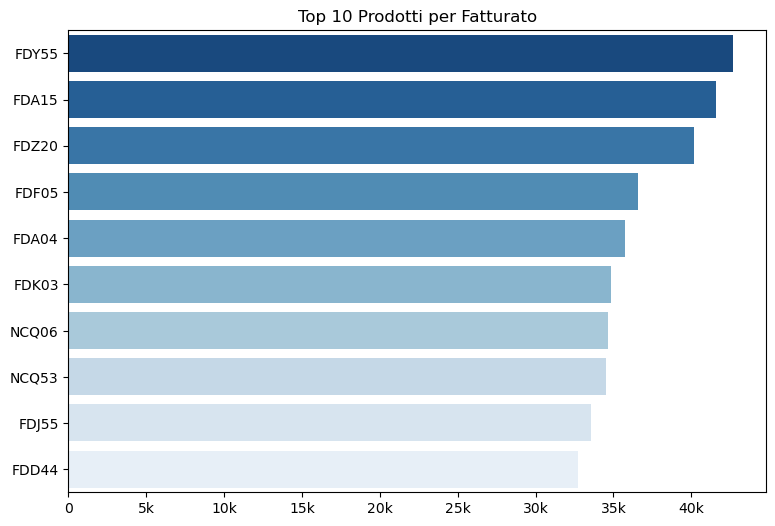

In [40]:
#creazione del grafico
top10_products_plot=top10_products.reset_index()
plt.figure(figsize=(9,6))
sns.barplot(x="OutletSales", y="ProductID", data=top10_products_plot, hue="ProductID", palette="Blues_r")
ax = plt.gca()
format_sales_axis(ax, axis='x')
plt.title("Top 10 Prodotti per Fatturato")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [41]:
# verifico la regola di Pareto, ovvero l'euristica secondo la quale l'80% del fatturato è generato dal 20% delle cause
pareto_products = df.groupby('ProductID')['OutletSales'].sum().sort_values(ascending=False).reset_index()

pareto_products['CumSales'] = pareto_products['OutletSales'].cumsum()
total_sales = pareto_products['OutletSales'].sum()

pareto_products['CumPerc'] = pareto_products['CumSales'] / total_sales * 100

In [42]:
fatt_pareto_80=pareto_products[pareto_products['CumPerc'] <= 80].shape[0] / pareto_products.shape[0]
fatt_pareto_80

0.5772931366260423

In [43]:
# in questo caso, si arriva al 80% del fatturato grazie al 57.7% dei prodotti con OutletSales maggiore

In [44]:
# FATTURATO PER CATEGORIA
category_sales=df.groupby("ProductType")["OutletSales"].sum().sort_values(ascending=False)
category_sales

ProductType
Fruits and Vegetables    2820059.87
Snack Foods              2732786.09
Household                2055493.85
Frozen Foods             1825734.96
Dairy                    1522594.03
Canned                   1444151.53
Baking Goods             1265525.36
Health and Hygiene       1045200.08
Meat                      917565.48
Soft Drinks               892897.63
Breads                    553237.21
Hard Drinks               457793.44
Starchy Foods             351401.26
Others                    325517.58
Breakfast                 232298.98
Seafood                   148868.17
Name: OutletSales, dtype: float64

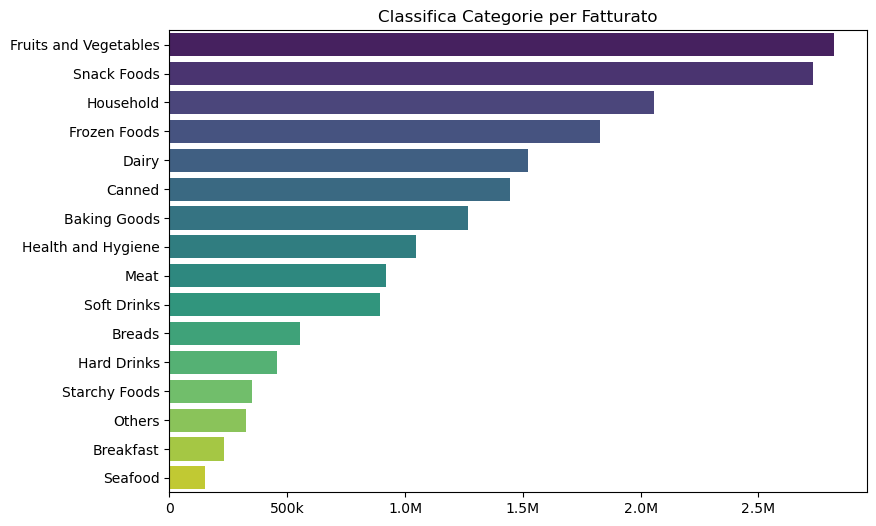

In [45]:
# Creazione del grafico
category_sales_plot = category_sales.reset_index()

plt.figure(figsize=(9, 6))
sns.barplot(x='OutletSales', y='ProductType', data=category_sales_plot, hue='ProductType', palette='viridis')
ax = plt.gca()
format_sales_axis(ax, axis='x')
plt.title("Classifica Categorie per Fatturato")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

In [46]:
# verifico la regola di Pareto 80/20
pareto_product_type = df.groupby('ProductType')['OutletSales'].sum().sort_values(ascending=False).reset_index()

pareto_product_type['CumSales'] = pareto_product_type['OutletSales'].cumsum()
total_sales = pareto_product_type['OutletSales'].sum()

pareto_product_type['CumPerc'] = pareto_product_type['CumSales'] / total_sales * 100
pareto_product_type[pareto_product_type['CumPerc'] <= 80].shape[0] / pareto_product_type.shape[0]

0.5

In [47]:
#fatturato per outlet
store_sales=df.groupby("OutletID")["OutletSales"].sum().sort_values(ascending=False)
store_sales

OutletID
OUT027    3453925.90
OUT035    2268122.99
OUT049    2183969.83
OUT017    2167465.48
OUT013    2142663.55
OUT046    2118395.22
OUT045    2036725.52
OUT018    1851822.81
OUT010     188340.12
OUT019     179694.10
Name: OutletSales, dtype: float64

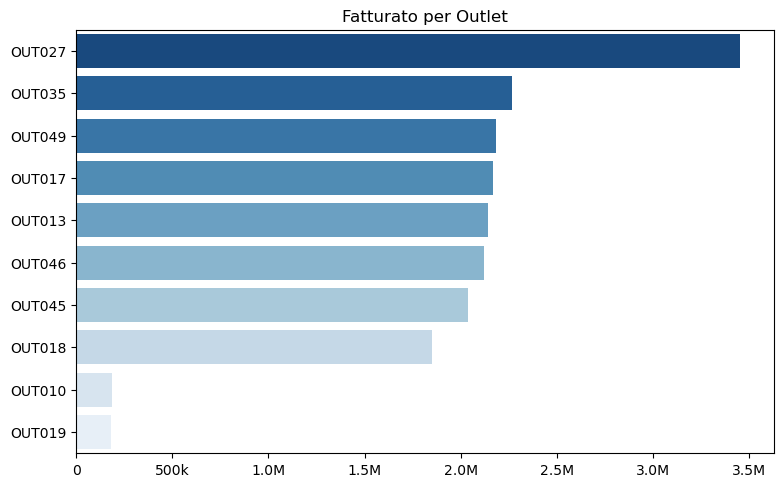

In [48]:
# Creazione del grafico
store_sales_plot = store_sales.reset_index()

plt.figure(figsize=(9, 5.5))
sns.barplot(x='OutletSales', y='OutletID', data=store_sales_plot, hue='OutletID', palette='Blues_r')
ax = plt.gca()
format_sales_axis(ax, axis='x')
plt.title("Fatturato per Outlet")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

In [49]:
# verifico la regola di Pareto 80/20
pareto_outlet = df.groupby('OutletID')['OutletSales'].sum().sort_values(ascending=False).reset_index()

pareto_outlet['CumSales'] = pareto_outlet['OutletSales'].cumsum()
total_sales = pareto_outlet['OutletSales'].sum()

pareto_outlet['CumPerc'] = pareto_outlet['CumSales'] / total_sales * 100
pareto_outlet[pareto_outlet['CumPerc'] <= 80].shape[0] / pareto_outlet.shape[0]

0.6

In [50]:
# ora voglio calcolare la performance degli store in base agli SKU
# Raggruppiamo per Outlet e calcoliamo fatturato e SKU unici per ognuno
outlet_stats = df.groupby('OutletID').agg(Fatturato_Outlet=('OutletSales', 'sum'),Num_SKU_Outlet=('ProductID', 'nunique'))

# Calcoliamo la metrica per ogni outlet
outlet_stats['Sales_per_SKU'] = (outlet_stats['Fatturato_Outlet'] / outlet_stats['Num_SKU_Outlet']).round(2)
media_benchmark = outlet_stats['Sales_per_SKU'].mean()
outlet_stats['Productivity_Index'] = (outlet_stats['Sales_per_SKU'] / media_benchmark).round(2)
outlet_stats_desc=outlet_stats.sort_values(by="Productivity_Index", ascending=False)
outlet_stats_desc

,Fatturato_Outlet,Num_SKU_Outlet,Sales_per_SKU,Productivity_Index
OutletID,,,,
OUT027,3453925.90,935,3694.04,1.82
OUT035,2268122.99,930,2438.84,1.20
OUT049,2183969.83,930,2348.35,1.16
OUT017,2167465.48,926,2340.68,1.15
OUT013,2142663.55,932,2299.00,1.13
OUT046,2118395.22,930,2277.84,1.12
OUT045,2036725.52,929,2192.38,1.08
OUT018,1851822.81,928,1995.50,0.98
OUT010,188340.12,555,339.35,0.17


In [51]:
# da questa tabella si nota come OUT027 sia lo store con la performance migliore.
# tutti gli store con Productivity_Index >1 si comportano meglio della media, con OUT018 di poco sotto
# gli store OUT019 e OUT010 sono i peggiori in termini di performance, cioè i prodotti al loro interno sotto-performano
# in termini di medie. Per quanto siano Grocery Store si dovrebbe comunque valutare un'ottimizzazione dell'assortimento

In [52]:
#posso espandere l'analisi del fatturato anche al tipo di outlet e alla locazione 
#OutlesSales per tipologia
outlet_type_sales=df.groupby("OutletType")["OutletSales"].sum().sort_values(ascending=False)
outlet_type_sales

OutletType
Supermarket Type1    12917342.59
Supermarket Type3     3453925.90
Supermarket Type2     1851822.81
Grocery Store          368034.22
Name: OutletSales, dtype: float64

In [53]:
# i supermarket di tipo1 generano un fatturato di 13 Milioni

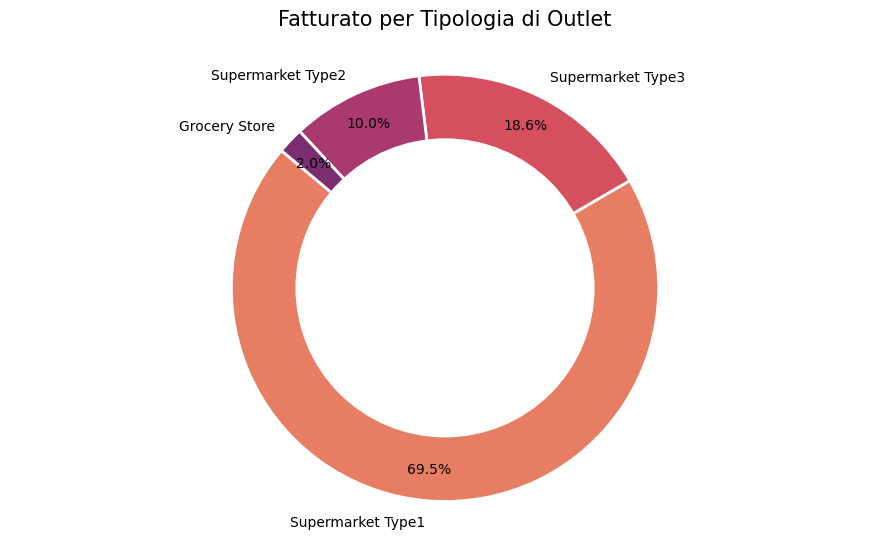

In [54]:
#creazione del grafico a torta
plt.figure(figsize=(9, 5.5))
colors = sns.color_palette("flare", n_colors=len(outlet_type_sales))

plt.pie(
    outlet_type_sales, 
    labels=outlet_type_sales.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2})

#Aggiunta di un cerchio al centro per renderlo un "Donut Chart"
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fatturato per Tipologia di Outlet", fontsize=15, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [55]:
#OutletSales per locazione
location_type_sales=df.groupby("LocationType")["OutletSales"].sum().sort_values(ascending=False)
location_type_sales

LocationType
Tier 3    7636752.38
Tier 2    6472313.99
Tier 1    4482059.15
Name: OutletSales, dtype: float64

(array([0, 1, 2]),
 [Text(0, 0, 'Tier 3'), Text(1, 0, 'Tier 2'), Text(2, 0, 'Tier 1')])

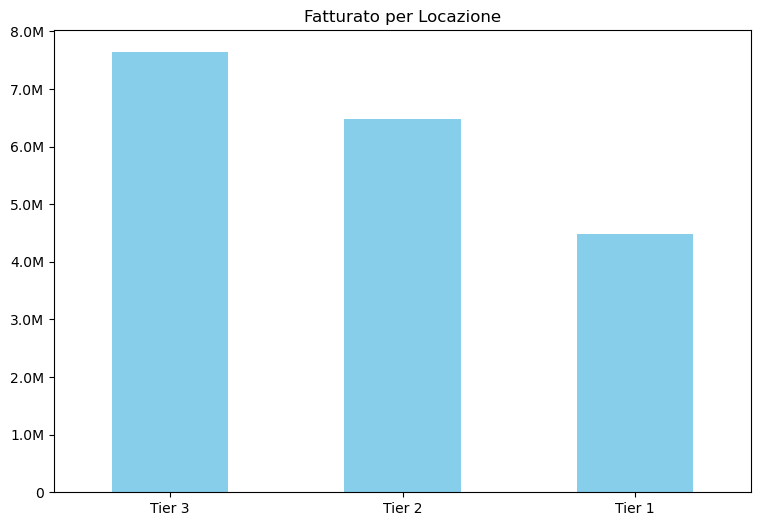

In [56]:
#creazione del grafico (veloce)
plt.figure(figsize=(9,6))
location_type_sales.plot(kind="bar", color="skyblue")
ax = plt.gca()
format_sales_axis(ax, axis='y')
plt.title("Fatturato per Locazione")
plt.xlabel("")
plt.xticks(rotation=0)

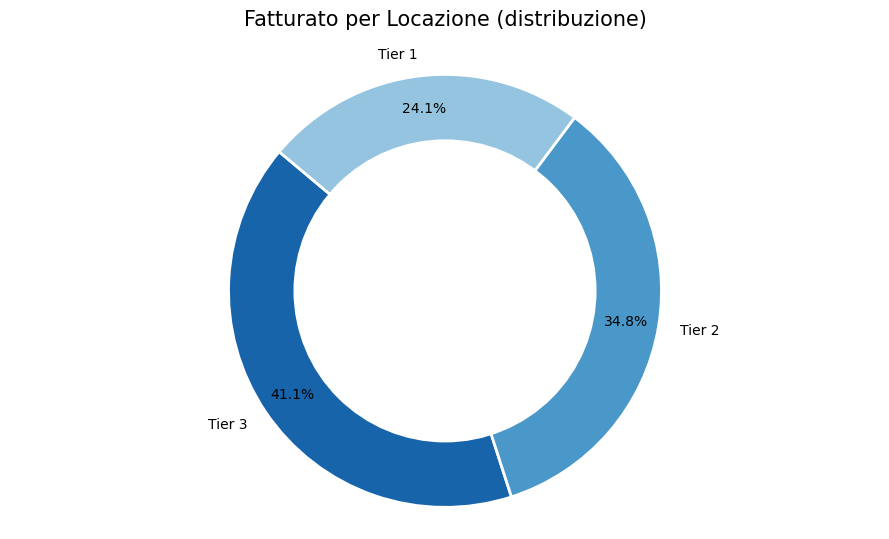

In [57]:
#creazione del grafico a torta
plt.figure(figsize=(9, 5.5))
colors = sns.color_palette("Blues_r", n_colors=len(outlet_type_sales))

plt.pie(
    location_type_sales, 
    labels=location_type_sales.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2})

#Aggiunta di un cerchio al centro per renderlo un "Donut Chart"
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fatturato per Locazione (distribuzione)", fontsize=15, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [58]:
# Risultati analisi preliminare del fatturato:
# “Il prodotto FDY55 è il principale generatore di OutletSales con 42661$, secondo FDA15 con 41584$ e terzo FDZ20 con 40185$ ;
# la categoria Fruits and Vegetables contribuisce maggiormente al fatturato totale con 2.8M$, segue Snack Foods con 2.7M$ ;
# l'outlet che genera più incassi è OUT027 (3.4M$), i due con meno incassi sono OUT010 (188k$) e OUT019 (179k$)
# i Supermarket Type1 sono il formato più performante (12.9M$) ben il 69.5% del totale;
# gli outlet con locazione Tier3 portano 7.6M$ (41.1% del totale)."

### Ranking per fascia di prezzo

In [59]:
# Individuazione dei Best Seller per fascia di prezzo
priceband_product_sales=df.groupby(["PriceBand","ProductID"], observed=True)["OutletSales"].sum().reset_index()
#creazione dei rank
priceband_product_sales['rank'] = (
    priceband_product_sales
    .groupby('PriceBand', observed=True)['OutletSales']
    .rank(method='dense', ascending=False))
#filtro per mostrare solo i 3 prodotti a fatturato maggiore per ogni fascia di prezzo
top_products_by_priceband = priceband_product_sales[priceband_product_sales['rank'] <= 3].sort_values(['PriceBand', 'rank'])
top_products_by_priceband

,PriceBand,ProductID,OutletSales,rank
340,Low,NCB18,14876.62,1.0
113,Low,FDG38,14146.93,2.0
242,Low,FDS33,12574.30,3.0
552,Mid-Low,FDL34,22866.23,1.0
426,Mid-Low,DRQ35,18204.29,2.0
540,Mid-Low,FDK20,18131.08,3.0
1226,Mid-High,NCY18,29067.49,1.0
1091,Mid-High,FDV57,28223.27,2.0
1120,Mid-High,FDX58,27830.43,3.0
1548,High,FDY55,42661.81,1.0


In [60]:
# Valutando solo il fatturato, i prodotti high price mostrano una maggiore concentrazione di fatturato

In [61]:
# verifico che ciascun prodotto appartenga ad una sola fascia di prezzo
df.groupby('ProductID')['PriceBand'].nunique().value_counts()

PriceBand
1    1482
2      77
Name: count, dtype: int64

In [62]:
# scopro che 77/1559 prodotti appartengono a 2 fasce di prezzo diverse.
# questo perché gli MRP variavano leggermente e ho deciso di mantenere i valori originali.
# vado a normalizzare gli MRP, utilizzando la media
mrp_mean = df.groupby('ProductID')['MRP'].mean()

df['PriceBand'] = pd.qcut(mrp_mean,q=4,labels=['Low', 'Mid-Low', 'Mid-High', 'High']).reindex(df['ProductID']).values

In [63]:
# Individuazione dei prodotti a fatturato maggiore per fascia di prezzo
priceband_product_sales=df.groupby(["PriceBand","ProductID"], observed=True)["OutletSales"].sum().reset_index()
#creazione dei rank
priceband_product_sales['rank'] = (
    priceband_product_sales
    .groupby('PriceBand', observed=True)['OutletSales']
    .rank(method='dense', ascending=False))
#filtro per mostrare solo i 3 prodotti a fatturato maggiore per ogni fascia di prezzo
top_products_by_priceband = priceband_product_sales[priceband_product_sales['rank'] <= 3].sort_values(['PriceBand', 'rank'])
top_products_by_priceband

,PriceBand,ProductID,OutletSales,rank
331,Low,NCB18,14876.62,1.0
108,Low,FDG38,14146.93,2.0
235,Low,FDS33,12574.30,3.0
529,Mid-Low,FDL34,25124.62,1.0
410,Mid-Low,DRQ35,18204.29,2.0
517,Mid-Low,FDK20,18131.08,3.0
1164,Mid-High,NCY18,29067.49,1.0
1037,Mid-High,FDV57,28223.27,2.0
1066,Mid-High,FDX58,27830.43,3.0
1473,High,FDY55,42661.81,1.0


In [64]:
# verifico che ciascun prodotto appartenga ad una sola fascia di prezzo
df.groupby('ProductID')['PriceBand'].nunique().value_counts()

PriceBand
1    1559
Name: count, dtype: int64

In [65]:
# È stata verificata la coerenza delle fasce di prezzo per prodotto, utilizzando il valore medio di prezzo

In [66]:
# assegno le fasce in modo da avere un grafico in ordine dalla fascia più alta alla più bassa
priceband_order = ['Low', 'Mid-Low', 'Mid-High', 'High']

top_products_by_priceband_sorted = (top_products_by_priceband.assign(PriceBand=pd.Categorical(
            top_products_by_priceband['PriceBand'],
            categories=priceband_order,
            ordered=True))
    .sort_values(['PriceBand', 'OutletSales'],ascending=[False, False]))

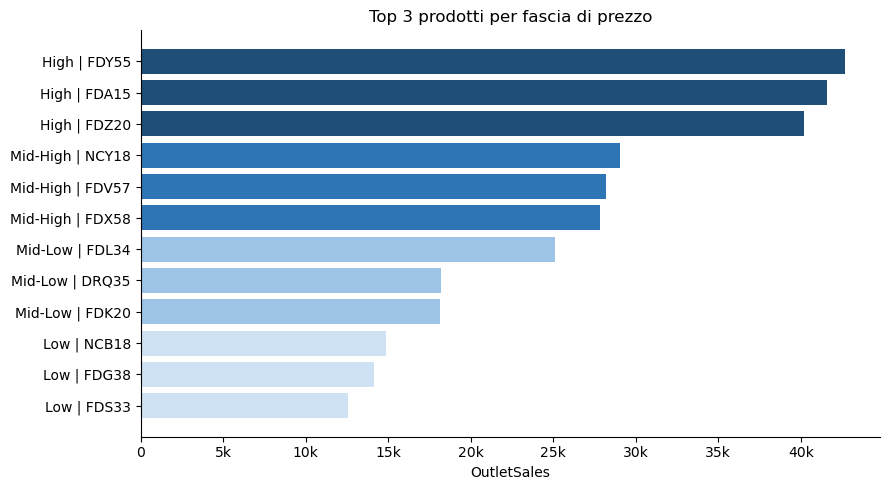

In [67]:
top_products_by_priceband_sorted['label'] = (
    top_products_by_priceband_sorted['PriceBand'].astype(str)
    + ' | '
    + top_products_by_priceband_sorted['ProductID']
)

plt.figure(figsize=(9, 5))
#assegno dei colori diversi per fascia
priceband_colors = {
    'High': '#1f4e79',      
    'Mid-High': '#2e75b6',  
    'Mid-Low': '#9dc3e6',    
    'Low': '#cfe2f3'}
colors = top_products_by_priceband_sorted['PriceBand'].map(priceband_colors)

plt.barh(
    top_products_by_priceband_sorted['label'],
    top_products_by_priceband_sorted['OutletSales'],
    color=colors)

ax = plt.gca()
format_sales_axis(ax, axis='x')

plt.xlabel('OutletSales')
plt.ylabel('')
plt.title('Top 3 prodotti per fascia di prezzo')

plt.gca().invert_yaxis()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [68]:
# dal grafico si nota come il prodotto FDL34 nonostante sia di fascia Mid-Low raggiunge un fatturato paragonabile a 
# quello dei prodotti di fascia Mid-High

In [69]:
# vorrei analizzare quanta % del fatturato deriva dalle fasce di prezzo dei prodotti
priceband_sales=df.groupby("PriceBand", observed=True)["OutletSales"].sum().sort_values(ascending=False)

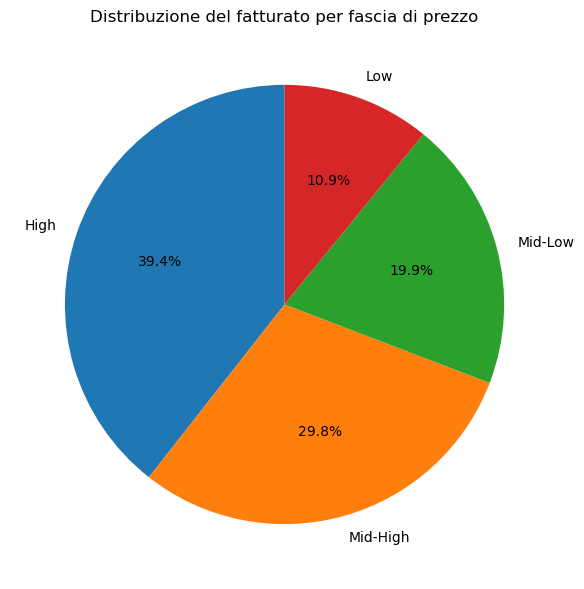

In [70]:
#creazione del grafico a torta
plt.figure(figsize=(6, 6))
plt.pie(
    priceband_sales,
    labels=priceband_sales.index,
    autopct='%1.1f%%',
    startangle=90)
plt.title('Distribuzione del fatturato per fascia di prezzo')
plt.tight_layout()
plt.show()

## Analisi per EUS (vendite stimate)

In [71]:
df.head(1)

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales,VisibilityZero,PriceBand,EstimatedUnitsSold,OutletAge
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14,False,High,14.95,26


In [72]:
# aggrego i volumi stimati per prodotto
Total_volume_est= df.groupby("ProductID")["EstimatedUnitsSold"].sum().sort_values(ascending=False)
print(Total_volume_est)

ProductID
NCL31    183.84
FDO19    183.07
FDW13    177.90
FDL34    177.80
FDJ21    173.10
          ...  
FDT35     11.01
NCR42      9.86
DRF48      7.95
FDY43      3.97
FDQ60      0.99
Name: EstimatedUnitsSold, Length: 1559, dtype: float64


In [73]:
#mostro solo la top10
top10_best_seller=Total_volume_est.head(10)

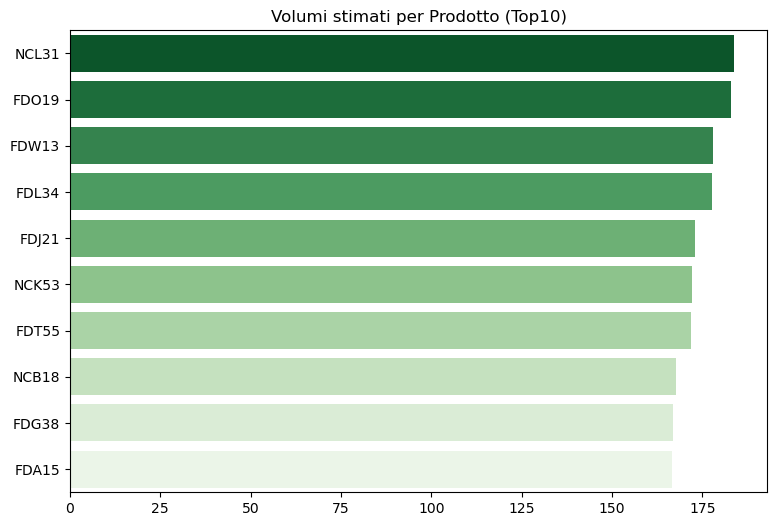

In [74]:
# Creazione del grafico
top10_best_seller_plot=top10_best_seller.reset_index()
plt.figure(figsize=(9, 6))
sns.barplot(x='EstimatedUnitsSold', y='ProductID', data=top10_best_seller_plot, hue='ProductID', palette='Greens_r')

plt.title("Volumi stimati per Prodotto (Top10)")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

In [75]:
# verifico la regola di Pareto, ovvero l'euristica secondo la quale l'80% delle vendite stimate è generato dal 20% degli SKU
pareto_volumes = df.groupby('ProductID')['EstimatedUnitsSold'].sum().sort_values(ascending=False).reset_index()

pareto_volumes['CumVolumes'] = pareto_volumes['EstimatedUnitsSold'].cumsum()
total_volumes = pareto_volumes['EstimatedUnitsSold'].sum()

pareto_volumes['CumPerc'] = pareto_volumes['CumVolumes'] / total_volumes * 100

In [76]:
EUS_pareto_80=pareto_volumes[pareto_volumes['CumPerc'] <= 80].shape[0] / pareto_volumes.shape[0]
EUS_pareto_80

0.6741500962155228

In [77]:
# in questo caso, si arriva al 80% delle vendite stimate grazie al 67.4% dei prodotti con EUS maggiore

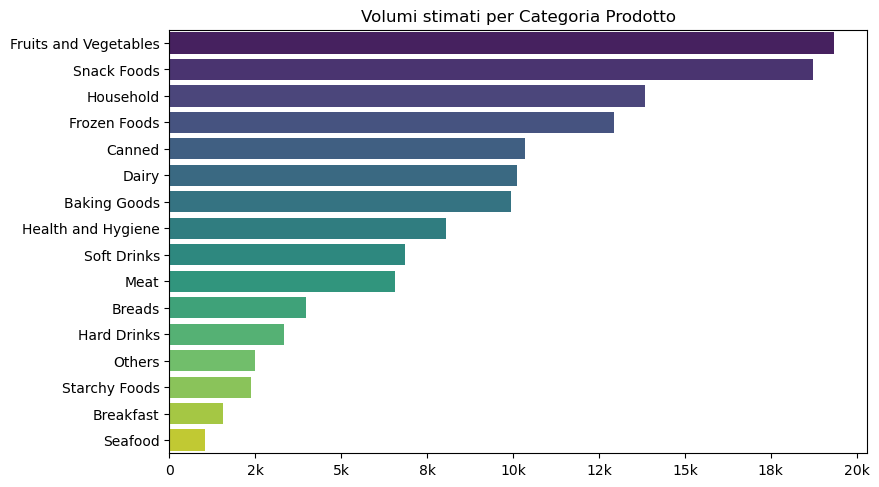

In [78]:
# Creazione del grafico volumi stimati per categoria
category_EUS=df.groupby("ProductType")["EstimatedUnitsSold"].sum().sort_values(ascending=False)
category_EUS_plot = category_EUS.reset_index()

plt.figure(figsize=(9, 5.5))
sns.barplot(x='EstimatedUnitsSold', y='ProductType', data=category_EUS_plot, hue='ProductType', palette='viridis')

ax = plt.gca()
format_sales_axis(ax, axis='x')
plt.title("Volumi stimati per Categoria Prodotto")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

In [79]:
# volume stimato per outlet
store_volumes=df.groupby("OutletID")["EstimatedUnitsSold"].sum().sort_values(ascending=False)
store_volumes

OutletID
OUT027    24879.52
OUT035    15785.79
OUT049    15466.20
OUT017    15427.03
OUT046    15057.83
OUT013    14913.29
OUT045    14475.89
OUT018    12854.41
OUT010     1322.69
OUT019     1290.79
Name: EstimatedUnitsSold, dtype: float64

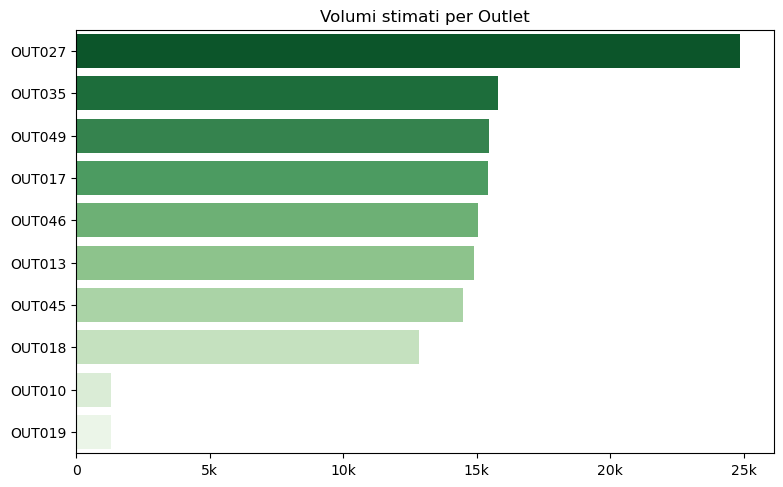

In [80]:
# Creazione del grafico
store_volumes_plot = store_volumes.reset_index()

plt.figure(figsize=(9, 5.5))
sns.barplot(x='EstimatedUnitsSold', y='OutletID', data=store_volumes_plot, hue='OutletID', palette='Greens_r')
ax = plt.gca()
format_sales_axis(ax, axis='x')
plt.title("Volumi stimati per Outlet")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

In [81]:
# Volumi stimati per tipologia
outlet_type_volumes=df.groupby("OutletType")["EstimatedUnitsSold"].sum().sort_values(ascending=False)
outlet_type_volumes

OutletType
Supermarket Type1    91126.03
Supermarket Type3    24879.52
Supermarket Type2    12854.41
Grocery Store         2613.48
Name: EstimatedUnitsSold, dtype: float64

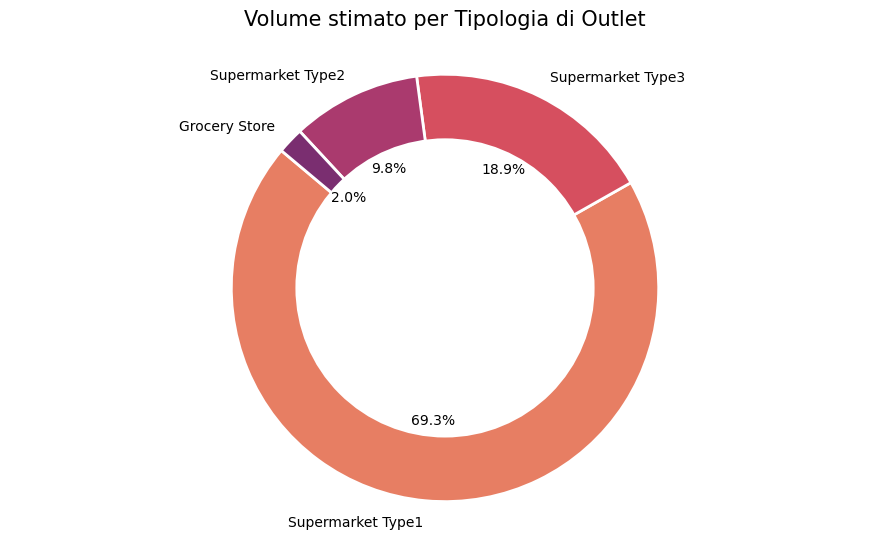

In [82]:
#creazione del grafico a torta
plt.figure(figsize=(9, 5.5))
colors = sns.color_palette("flare", n_colors=len(outlet_type_sales))

plt.pie(
    outlet_type_volumes, 
    labels=outlet_type_volumes.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    pctdistance=0.62,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2})

#Aggiunta di un cerchio al centro per renderlo un "Donut Chart"
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Volume stimato per Tipologia di Outlet", fontsize=15, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [83]:
# Volume stimato per locazione
location_type_volumes=df.groupby("LocationType")["EstimatedUnitsSold"].sum().sort_values(ascending=False)
location_type_volumes

LocationType
Tier 3    53969.91
Tier 2    45688.71
Tier 1    31814.82
Name: EstimatedUnitsSold, dtype: float64

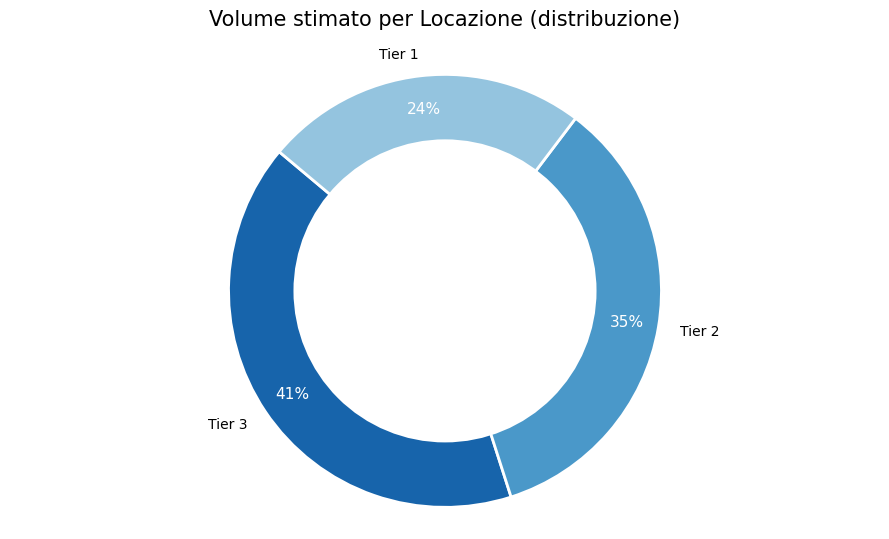

In [84]:
#creazione del grafico a torta
plt.figure(figsize=(9, 5.5))
colors = sns.color_palette("Blues_r", n_colors=len(outlet_type_sales))

wedges, texts, autotexts=plt.pie(
    location_type_volumes, 
    labels=location_type_volumes.index, 
    autopct='%1.0f%%', 
    startangle=140, 
    colors=colors,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2})

# scritte all'interno del grafico in bianco
for text in autotexts:
    text.set_color('white')
    text.set_fontsize(11)
    
#Aggiunta di un cerchio al centro per renderlo un "Donut Chart"
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Volume stimato per Locazione (distribuzione)", fontsize=15, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [85]:
# su queste ultime features, l'analisi dei volumi stimati porta a risultati sovrapponibili con quelli dell'analisi sul fatturato

### Ranking per fascia di prezzo

In [86]:
# Individuazione dei Best Seller per fascia di prezzo
priceband_best_seller=df.groupby(["PriceBand","ProductID"], observed=True)["EstimatedUnitsSold"].sum().reset_index()
#creazione dei rank
priceband_best_seller['rank'] = (
    priceband_best_seller
    .groupby('PriceBand', observed=True)['EstimatedUnitsSold']
    .rank(method='dense', ascending=False))
#filtro per mostrare solo i 3 prodotti con volume di vendita stimato maggiore per ogni fascia di prezzo
best_seller_by_priceband = priceband_best_seller[priceband_best_seller['rank'] <= 3].sort_values(['PriceBand', 'rank'])
best_seller_by_priceband

,PriceBand,ProductID,EstimatedUnitsSold,rank
185,Low,FDO19,183.07,1.0
284,Low,FDW13,177.90,2.0
331,Low,NCB18,167.73,3.0
529,Mid-Low,FDL34,177.80,1.0
722,Mid-Low,NCK53,172.12,2.0
683,Mid-Low,FDZ35,153.57,3.0
1122,Mid-High,NCL31,183.84,1.0
907,Mid-High,FDJ21,173.10,2.0
1009,Mid-High,FDT55,171.79,3.0
1202,High,FDA15,166.62,1.0


In [87]:
# verifico che ciascun prodotto appartenga ad una sola fascia di prezzo
df.groupby('ProductID')['PriceBand'].nunique().value_counts()

PriceBand
1    1559
Name: count, dtype: int64

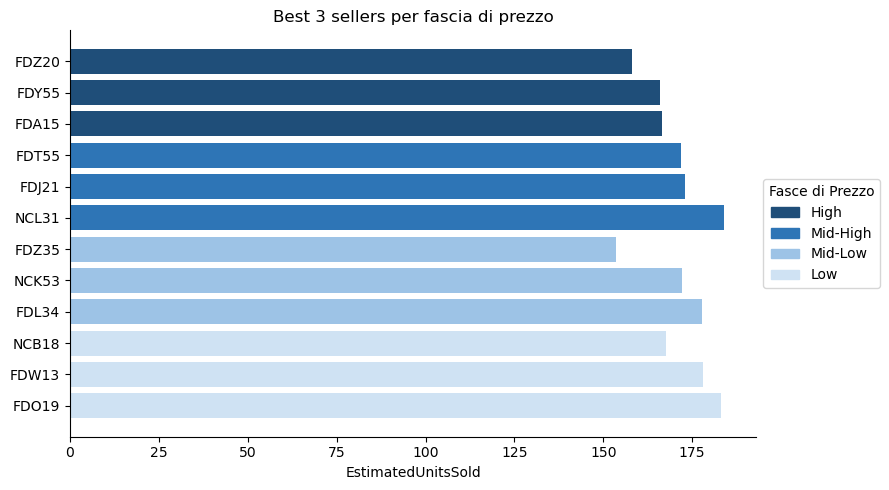

In [88]:
#creazione del grafico con legenda 
import matplotlib.patches as mpatches

plt.figure(figsize=(9, 5))
#assegno dei colori diversi per fascia
priceband_colors = {
    'High': '#1f4e79',      
    'Mid-High': '#2e75b6',  
    'Mid-Low': '#9dc3e6',    
    'Low': '#cfe2f3'         }
colors = best_seller_by_priceband['PriceBand'].map(priceband_colors)

plt.barh(
    best_seller_by_priceband['ProductID'],
    best_seller_by_priceband['EstimatedUnitsSold'],
    color=colors)
# Creazione della legenda
legend_handles = [
    mpatches.Patch(color=color, label=label) 
    for label, color in priceband_colors.items()]

# Aggiungiamo la legenda al grafico
plt.legend(handles=legend_handles, title="Fasce di Prezzo", bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel('EstimatedUnitsSold')
plt.ylabel('')
plt.title('Best 3 sellers per fascia di prezzo')
#rimuovo gli assi a destra e in alto
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [89]:
# da questa analisi si vede che i 3 best seller per fascia hanno tutti volumi stimati simili compresi tra 158 e 184

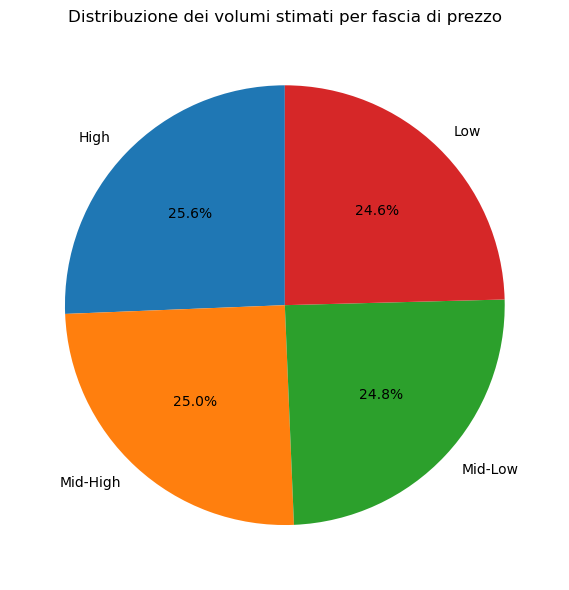

In [90]:
# analizzo quanta % dei volumi stimati deriva dalle fasce di prezzo
priceband_volumes=df.groupby("PriceBand", observed=True)["EstimatedUnitsSold"].sum().sort_values(ascending=False)

#creazione del grafico a torta
plt.figure(figsize=(6, 6))
plt.pie(
    priceband_volumes,
    labels=priceband_sales.index,
    autopct='%1.1f%%',
    startangle=90)
plt.title('Distribuzione dei volumi stimati per fascia di prezzo')
plt.tight_layout()
plt.show()

In [91]:
# proprio per come abbiamo definito i volumi stimati e le fasce di prezzo,
# era lecito aspettarsi una distribuzione quasi uniforme dei volumi per fascia di prezzo

## Matrice Valore/Volume

In [92]:
# procedo con la creazione della matrice valore-volume per segmentare i prodotti in base a queste due caratteristiche
# creazione del df con prodotto e rispettivo fatturato e unità stimate vendute
product_value_volume = (
    df.groupby('ProductID').agg(TotalSales=('OutletSales', 'sum'),TotalEUS=('EstimatedUnitsSold', 'sum')).reset_index())

In [93]:
# definisco le soglie utilizzando la mediana (per essere meno sensibile rispetto agli outlier)
value_threshold = product_value_volume['TotalSales'].median()
volume_threshold = product_value_volume['TotalEUS'].median()

In [94]:
volume_threshold

82.95

In [95]:
# assegno i quadranti in base ai valori in modo da individuare le classi di prodotto
def assign_quadrant(row):
    if row['TotalSales'] >= value_threshold and row['TotalEUS'] >= volume_threshold:
        return 'High Value – High Volume'
    elif row['TotalSales'] >= value_threshold and row['TotalEUS'] < volume_threshold:
        return 'High Value – Low Volume'
    elif row['TotalSales'] < value_threshold and row['TotalEUS'] >= volume_threshold:
        return 'Low Value – High Volume'
    else:
        return 'Low Value – Low Volume'

product_value_volume['Quadrant'] = product_value_volume.apply(assign_quadrant, axis=1)

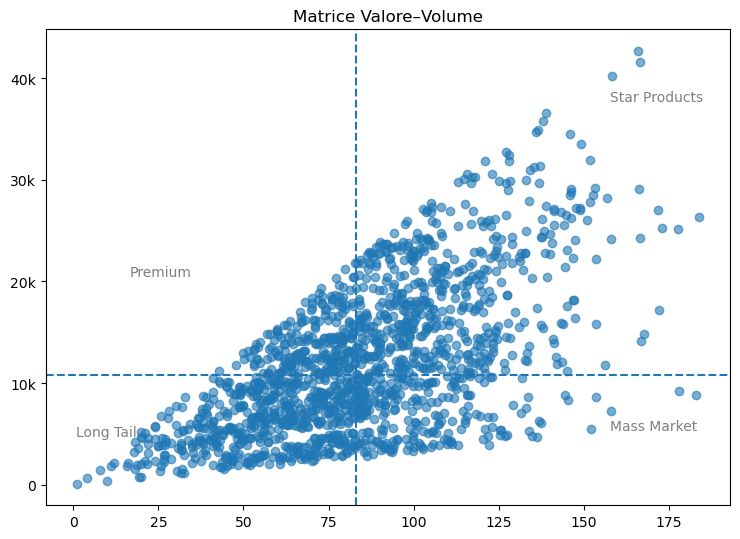

In [96]:
plt.figure(figsize=(7.5, 5.5))

plt.scatter(
    product_value_volume['TotalEUS'],
    product_value_volume['TotalSales'],
    alpha=0.6)

ax = plt.gca()
format_sales_axis(ax, axis='y')
plt.axhline(value_threshold, linestyle='--')
plt.axvline(volume_threshold, linestyle='--')

plt.xlabel('')
plt.ylabel('')
plt.title('Matrice Valore–Volume')

plt.text(volume_threshold*1.9, value_threshold*3.5, 'Star Products', alpha=0.5)
plt.text(volume_threshold*0.2, value_threshold*1.9, 'Premium', alpha=0.5)
plt.text(volume_threshold*1.9, value_threshold*0.5, 'Mass Market', alpha=0.5)
plt.text(volume_threshold*0.01, value_threshold*0.45, 'Long Tail', alpha=0.5)
plt.tight_layout()
plt.show()

In [97]:
# I prodotti sono stati segmentati in una matrice valore–volume, evidenziando le quattro principali tipologie di performance
# da questo grafico non emergono prodotti che è possibile definire Premium (ovvero con poche unità vendute 
# ma grande fatturato), invece è facile individuare i due mass market in basso a destra, 
# così come i 3 prodotti star in alto a destra; in basso a sinistra ci sono i prodotti con volumi e fatturato minore, 
# degni di un'analisi ad hoc per capire se ci sono le condizioni per tenerli nell'assortimento oppure no.
# Da osservare anche il prodotto a destra nella parte centrale del grafico (area Star Products) che sembra essere il più venduto
# e riporta un fatturato di molto superiore ai mass market con stessi volumi di vendita

In [98]:
# creo una tabella di sintesi per avere una visione d'insieme su ogni quadrante
quadrant_summary = (
    product_value_volume.groupby('Quadrant').agg(
        SKU=('ProductID', 'nunique'),TotalSales=('TotalSales', 'sum'),TotalEUS=('TotalEUS', 'sum')).reset_index())

# quote percentuali
quadrant_summary['%_SKU']= (quadrant_summary['SKU']/quadrant_summary['SKU'].sum()*100).round(2)

quadrant_summary['%_Sales'] = (quadrant_summary['TotalSales'] /quadrant_summary['TotalSales'].sum() * 100).round(2)

quadrant_summary['%_EUS'] = (quadrant_summary['TotalEUS'] /quadrant_summary['TotalEUS'].sum() * 100).round(2)

quadrant_summary

,Quadrant,SKU,TotalSales,TotalEUS,%_SKU,%_Sales,%_EUS
0,High Value – High Volume,546,10367236.08,60445.05,35.02,55.76,45.98
1,High Value – Low Volume,234,3293653.71,16499.44,15.01,17.72,12.55
2,Low Value – High Volume,234,1688254.26,23861.97,15.01,9.08,18.15
3,Low Value – Low Volume,545,3241981.47,30666.98,34.96,17.44,23.33


In [99]:
# la fascia High Value - High Volume è il cuore economico dell'assortimento, il 35% degli SKU genera il 55.7% del fatturato e 
# il 45.9% dei volumi. Questo suggerisce che i prodotti al suo interno appartengono prevalentemente a categorie di largo consumo 
# ad alta rotazione e fascia di prezzo elevata
# => proteggere con strategie di pricing, visibilità, etc.

# la fascia High Value - Low Volume genera il 17.7% del fatturato nonostante sia il 15% degli SKU
# => pricing selettivo, gestione mirata

# la fascia Low Value – High Volume genera solamente il 9% del fatturato (15% degli SKU) 
# => analisi dei costi

# la fascia Low Value – Low Volume è rappresentata dal 35% degli SKU, genera il 17.4% del fatturato e il 23.3% del volume
# => razionalizzazione per categoria/store, analisi di assortimento, etc.

In [100]:
# metto in ordine i prodotti per visualizzare i top e i worst performer
product_value_volume.sort_values(['Quadrant', 'TotalSales'],ascending=[True, False])

,ProductID,TotalSales,TotalEUS,Quadrant
1210,FDY55,42661.81,166.05,High Value – High Volume
156,FDA15,41584.54,166.62,High Value – High Volume
1230,FDZ20,40185.02,158.16,High Value – High Volume
359,FDF05,36555.75,139.03,High Value – High Volume
148,FDA04,35741.49,137.94,High Value – High Volume
...,...,...,...,...
777,FDQ04,784.31,19.86,Low Value – Low Volume
379,FDF38,771.66,19.23,Low Value – Low Volume
1200,FDY43,673.79,3.97,Low Value – Low Volume
1474,NCR42,332.90,9.86,Low Value – Low Volume


### Star Products

In [101]:
# focus sugli star products
star_products = product_value_volume[product_value_volume['Quadrant'] == 'High Value – High Volume'
].sort_values('TotalSales', ascending=False)

star_products_enriched = (df.merge(star_products[['ProductID']],on='ProductID')
                        .groupby(['ProductID', 'ProductType', 'PriceBand'],observed=True)
                        .agg(TotalSales=('OutletSales', 'sum'),TotalUnits=('EstimatedUnitsSold', 'sum'))
                        .reset_index().sort_values('TotalSales', ascending=False))

star_products_enriched.head(11)

,ProductID,ProductType,PriceBand,TotalSales,TotalUnits
419,FDY55,Fruits and Vegetables,High,42661.81,166.05
45,FDA15,Dairy,High,41584.54,166.62
427,FDZ20,Fruits and Vegetables,High,40185.02,158.16
107,FDF05,Frozen Foods,High,36555.75,139.03
42,FDA04,Frozen Foods,High,35741.49,137.94
178,FDK03,Dairy,High,34843.98,136.45
506,NCQ06,Household,High,34680.20,136.09
509,NCQ53,Health and Hygiene,High,34508.41,146.10
174,FDJ55,Meat,High,33531.01,149.13
93,FDD44,Fruits and Vegetables,High,32723.41,127.10


In [102]:
# I prodotti Star appartengono principalmente alle categorie Fruits and Vegetables, Dairy e Frozen Foods
# mantengono volumi consistenti (appartengono a categoria di largo consumo) significa che il prezzo è accettato dal mercato
# e che la domanda è stabile => mantenere alta disponibilità, evitare sconti aggressivi e out-of-stock

In [103]:
# confronto le caratteristiche del quadrante Star Products con i top3 
star_products_enriched[['TotalSales', 'TotalUnits']].describe()

,TotalSales,TotalUnits
count,546.000000,546.000000
mean,18987.611868,110.705220
std,5742.121944,19.874205
min,10872.500000,82.950000
25%,14373.282500,95.867500
50%,17911.685000,105.950000
75%,22795.167500,122.102500
max,42661.810000,183.840000


In [104]:
star_products_enriched.head(3)

,ProductID,ProductType,PriceBand,TotalSales,TotalUnits
419,FDY55,Fruits and Vegetables,High,42661.81,166.05
45,FDA15,Dairy,High,41584.54,166.62
427,FDZ20,Fruits and Vegetables,High,40185.02,158.16


In [105]:
# da questo confronto noto che i top3 hanno un fattore moltiplicativo di 2.3 volte il fatturato mediano degli altri
# prodotti dello stesso quadrante (High Value – High Volume) e un volume maggiore del 52%.
# => sono i driver principali (come si nota dalla matrice valore/volume) su entrambi gli aspetti analizzati

In [106]:
# verifico la distribuzione del fatturato dei top3 star per OutletType
df[df['ProductID'].isin(['FDY55', 'FDA15', 'FDZ20'])].groupby(['ProductID', 'OutletType'])['OutletSales'].sum()

ProductID  OutletType       
FDA15      Grocery Store          498.02
           Supermarket Type1    28636.06
           Supermarket Type2     5976.22
           Supermarket Type3     6474.24
FDY55      Grocery Store          257.00
           Supermarket Type1    31610.86
           Supermarket Type2     1541.99
           Supermarket Type3     9251.96
FDZ20      Grocery Store          508.67
           Supermarket Type1    28231.25
           Supermarket Type3    11445.10
Name: OutletSales, dtype: float64

In [107]:
# FDZ20 vende meglio nei Grocery Store e nei Type 3 rispetto agli altri top di gamma.
# FDY55 ha il primato nei Type1 mentre FDA15 lo ha nei Type2.
# da notare la completa assenza di FDZ20 dai Type2 (che compongono il 10% dei volumi stimati) 
# => analisi delle cause, possibile domanda non soddisfatta!

In [108]:
# verifico la distribuzione del fatturato per Outlet
df[df['ProductID'].isin(['FDY55', 'FDA15', 'FDZ20'])].groupby(['ProductID', 'OutletID'])['OutletSales'].sum().unstack()

OutletID,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
ProductID,,,,,,,,,,
FDA15,498.02,6474.24,5976.22,5976.22,NaN,6474.24,6474.24,5976.22,NaN,3735.14
FDY55,NaN,7452.97,NaN,1541.99,257.0,9251.96,4111.98,8994.96,4625.98,6424.97
FDZ20,508.67,6867.06,2543.36,NaN,NaN,11445.10,5849.72,6358.39,3815.03,2797.69


In [109]:
# escludendo Out010 e Out019 (con fatturato con ordine di grandezza non paragonabile agli altri) si nota che FDA15 non ha vendite
# in Out046, FDY55 in Out017 e FDZ20 in Out018. Suggerisco di indagare sulle cause per capire se ci sono potenziali di mercato.
# i top3 reagiscono diversamente allo stesso outlet: FDY55 performa molto bene in OUT027 e OUT045;
# FDZ20 ha picchi in OUT027 e OUT013; FDA15 è più bilanciato tra OUT013 / OUT017 / OUT027
# mostrando sensibilità al contesto di vendita => strategie assortitive e di layout specifiche per store.

### Mass Market

In [110]:
# focus sui mass market
mass_market_products = product_value_volume[product_value_volume['Quadrant'] == 'Low Value – High Volume'
].sort_values('TotalEUS', ascending=False)

mass_market_products_with_cat = (mass_market_products.merge(
        df[['ProductID', 'ProductType']].drop_duplicates(),on='ProductID',how='left'))

mass_market_products_with_cat.head(5)

,ProductID,TotalSales,TotalEUS,Quadrant,ProductType
0,FDO19,8845.81,183.07,Low Value – High Volume,Fruits and Vegetables
1,FDW13,9192.03,177.90,Low Value – High Volume,Canned
2,FDO32,7270.52,157.98,Low Value – High Volume,Fruits and Vegetables
3,NCO54,8620.78,153.49,Low Value – High Volume,Household
4,DRF25,5492.85,152.01,Low Value – High Volume,Soft Drinks


In [111]:
# i top products per i Mass Market fanno parte delle categorie Fruits and Vegetables e Canned
# Questi prodotti guidano i volumi, mantengono rotazione elevata ma non sono pensati per massimizzare il fatturato unitario
# devono essere presenti in assortimento perchè appartengono a categorie alimentari di base che portano 
# l'acquirente ad entrare negli store (categoria core assortment) => bundle, cross-selling evitare out-of-stock

In [112]:
# verifico la distribuzione dei volumi per OutletType
mass_market_ids = ['FDO19','FDW13','FDO32','NCO54','DRF25']

mass_market_outlettype_pct = (df[df['ProductID'].isin(mass_market_ids)]
    .groupby(['ProductID', 'OutletType'], observed=True)['EstimatedUnitsSold'].sum().reset_index())

# totale volumi per prodotto
total_units_per_product = (mass_market_outlettype_pct.groupby('ProductID')['EstimatedUnitsSold'].transform('sum'))

# calcolo percentuale
mass_market_outlettype_pct['VolumeShare_%'] = (mass_market_outlettype_pct['EstimatedUnitsSold'] / total_units_per_product * 100)

mass_market_outlettype_pct.sort_values(['ProductID', 'VolumeShare_%'], ascending=[True, False])

,ProductID,OutletType,EstimatedUnitsSold,VolumeShare_%
1,DRF25,Supermarket Type1,115.64,76.073943
2,DRF25,Supermarket Type3,34.34,22.590619
0,DRF25,Grocery Store,2.03,1.335438
4,FDO19,Supermarket Type1,119.77,65.423062
6,FDO19,Supermarket Type3,46.14,25.203474
5,FDO19,Supermarket Type2,15.22,8.313760
3,FDO19,Grocery Store,1.94,1.059704
7,FDO32,Supermarket Type1,115.96,73.401696
8,FDO32,Supermarket Type2,22.56,14.280289
9,FDO32,Supermarket Type3,19.46,12.318015


In [113]:
# DRF25 non presenta volumi nei Type2 (10% dei volumi totali) => analisi cause, opportunità di test assortitivo nei Type2
# DRF25 al contempo ha il Volume% più alto nei Type1
# FDW13 ha il Volume% più alto nei Grocery, dimostrandosi un prodotto appetibile a prescindere dall'outlet type 
# NCO54 ha il Volume% più alto nei Type2 e nei Type3 e il più basso nei Type1, dimostrando di essere un prodotto
# con volumi dipendenti dalla tipologia di outlet

In [114]:
# verifico la distribuzione dei volumi per Outlet
df[df['ProductID'].isin(['FDO19','FDW13','FDO32','NCO54','DRF25'])].groupby(
    ['ProductID', 'OutletID'])['EstimatedUnitsSold'].sum().unstack()

OutletID,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
ProductID,,,,,,,,,,
DRF25,NaN,30.42,NaN,NaN,2.03,34.34,32.62,17.81,13.63,21.16
FDO19,1.94,28.87,19.73,15.22,NaN,46.14,20.72,11.11,16.10,23.24
FDO32,NaN,24.63,24.37,22.56,NaN,19.46,9.14,18.35,25.44,14.03
FDW13,6.07,17.47,5.08,18.21,4.11,47.27,26.41,13.41,22.74,17.13
NCO54,NaN,5.80,9.96,24.17,3.09,43.81,NaN,27.02,12.91,26.73


In [115]:
# escludendo Out010 e Out019 (volume con ordine di grandezza non paragonabile agli altri) si nota che DRF25 non presenta 
# vendite in due store distinti => approfondire cause
# FDW13 è l'unico tra i best seller del quadrante ad avere volumi di vendita in tutti gli Outlet

### Hybrid Products

In [116]:
# Dalla matrice valore/volume avevamo osservato due prodotti nel quadrante Star con volumi tra i maggiori
# ma con fatturato inferiore ai top del quadrante. 
# Questi prodotti hanno una performance ibrida e per questo meritano un'analisi ad hoc

In [117]:
median_sales = product_value_volume['TotalSales'].median()
median_units = product_value_volume['TotalEUS'].median()

print(f"Il fatturato mediano è {median_sales:.2f}, mentre il volume mediano è {median_units:.2f}")

Il fatturato mediano è 10785.96, mentre il volume mediano è 82.95


In [118]:
# identificazione degli hybrid products
hybrid_products = product_value_volume[
    (product_value_volume['TotalEUS'] > median_units) &
    (product_value_volume['TotalSales'] > median_sales) &
    (product_value_volume['TotalEUS'] > product_value_volume['TotalEUS'].quantile(0.998))
    ].sort_values(by='TotalEUS', ascending=False)

print(hybrid_products)

     ProductID  TotalSales  TotalEUS                  Quadrant
1383     NCL31    26339.05    183.84  High Value – High Volume
601      FDL34    25124.62    177.80  High Value – High Volume


In [119]:
# ora li confrontiamo con i top 3 mass market
comparison = product_value_volume[product_value_volume['ProductID'].isin(
        list(hybrid_products['ProductID']) +
        list(mass_market_products['ProductID'].head(3)))].sort_values(by='TotalEUS', ascending=False)
comparison

,ProductID,TotalSales,TotalEUS,Quadrant
1383,NCL31,26339.05,183.84,High Value – High Volume
702,FDO19,8845.81,183.07,Low Value – High Volume
1077,FDW13,9192.03,177.90,Low Value – High Volume
601,FDL34,25124.62,177.80,High Value – High Volume
712,FDO32,7270.52,157.98,Low Value – High Volume


In [120]:
# Dal confronto si vede che sono il primo e il quarto prodotto con volume stimato maggiore, quindi assolutamente
# paragonabili ai mass market ma con valore unitario superiore. 
# Date queste caratteristiche, possiamo definirli Mass Market Premium => potenziali leve strategiche per ottimizzazione mix vendita

### Long Tail

In [121]:
# focus sulla Long Tail
long_tail_sorted = (product_value_volume[product_value_volume['Quadrant'] == 'Low Value – Low Volume']
    .sort_values('TotalSales', ascending=True))

long_tail_sorted.head()

,ProductID,TotalSales,TotalEUS,Quadrant
819,FDQ60,120.51,0.99,Low Value – Low Volume
1474,NCR42,332.90,9.86,Low Value – Low Volume
1200,FDY43,673.79,3.97,Low Value – Low Volume
379,FDF38,771.66,19.23,Low Value – Low Volume
777,FDQ04,784.31,19.86,Low Value – Low Volume


In [122]:
# definisco una soglia sotto la quale vengono individuati i prodotti candidati alla razionalizzazione
rationalization_candidates = long_tail_sorted[(long_tail_sorted['TotalEUS'] < 0.2 * median_units) &
    (long_tail_sorted['TotalSales'] < 0.2 * median_sales)]

rationalization_candidates

,ProductID,TotalSales,TotalEUS,Quadrant
819,FDQ60,120.51,0.99,Low Value – Low Volume
1474,NCR42,332.90,9.86,Low Value – Low Volume
1200,FDY43,673.79,3.97,Low Value – Low Volume
46,DRF48,1496.72,7.95,Low Value – Low Volume
713,FDO33,1821.63,15.79,Low Value – Low Volume
945,FDT35,1845.60,11.01,Low Value – Low Volume
1173,FDY09,2101.27,12.06,Low Value – Low Volume
1006,FDU48,2109.26,16.02,Low Value – Low Volume


In [123]:
# il confronto tra i prodotti della Long Tail e i valori mediani di volume e fatturato evidenzia un sottoinsieme di SKU 
# con performance inferiori al 20% della mediana su entrambe le metriche. 
# Questi prodotti mostrano una marginalità strutturale e rappresentano candidati naturali 
# a interventi di razionalizzazione dell’assortimento, salvo specifiche logiche di nicchia o copertura

In [124]:
# Prima di procedere con la razionalizzazione dei prodotti Long Tail individuati, verifico se i dati insoddisfacenti
# siano dovuti a mancanza di prodotto negli assortimenti dei vari outlet oppure se proprio non c'è domanda per essi.
# inserisco quindi i rapporti di fatturato/n°outlet e quantità/n°outlet
sku_ubiquity = (df.groupby('ProductID').agg(NumOutlets=('OutletID', 'nunique'),TotalSales=('OutletSales', 'sum'),
          TotalEUS=('EstimatedUnitsSold', 'sum')).reset_index())

sku_ubiquity['Sales_per_Outlet'] = (sku_ubiquity['TotalSales'] /sku_ubiquity['NumOutlets'])

sku_ubiquity['EUS_per_Outlet'] = (sku_ubiquity['TotalEUS'] /sku_ubiquity['NumOutlets'])

sku_ubiquity_asc=sku_ubiquity.sort_values('Sales_per_Outlet', ascending=True)

sku_ubiquity_asc

,ProductID,NumOutlets,TotalSales,TotalEUS,Sales_per_Outlet,EUS_per_Outlet
1474,NCR42,3,332.90,9.86,110.966667,3.286667
819,FDQ60,1,120.51,0.99,120.510000,0.990000
777,FDQ04,3,784.31,19.86,261.436667,6.620000
1124,FDX10,4,1164.48,32.66,291.120000,8.165000
1413,NCN29,5,1555.31,32.00,311.062000,6.400000
...,...,...,...,...,...,...
106,DRK23,5,27324.43,107.91,5464.886000,21.582000
1255,FDZ50,2,11025.65,60.21,5512.825000,30.105000
1011,FDU55,4,23689.83,90.94,5922.457500,22.735000
1385,NCL42,3,17886.05,72.97,5962.016667,24.323333


In [125]:
# creo una matrice decisionale che permetta di individuare quali sono i prodotti della long tail su cui occorre intervenire
# e con quali decisioni consigliate
long_tail_products = product_value_volume[product_value_volume['Quadrant'] == 'Low Value – Low Volume']

In [126]:
long_tail_ids = long_tail_products['ProductID']

long_tail_decision = sku_ubiquity[sku_ubiquity['ProductID'].isin(long_tail_ids)].copy()

In [127]:
long_tail_decision

,ProductID,NumOutlets,TotalSales,TotalEUS,Sales_per_Outlet,EUS_per_Outlet
3,DRB01,3,4554.07,24.01,1518.023333,8.003333
9,DRC12,4,8949.68,47.08,2237.420000,11.770000
10,DRC13,4,6528.17,52.40,1632.042500,13.100000
11,DRC24,2,6305.80,41.13,3152.900000,20.565000
15,DRC49,3,8484.96,58.49,2828.320000,19.496667
...,...,...,...,...,...,...
1537,NCX53,2,4112.64,28.76,2056.320000,14.380000
1546,NCY42,4,10449.73,72.26,2612.432500,18.065000
1549,NCZ05,3,2063.98,19.84,687.993333,6.613333
1553,NCZ29,4,6669.32,52.84,1667.330000,13.210000


In [128]:
# imposto una soglia minima per i rapporti fatturato/outlet e unità/outlet 
sales_thr = long_tail_decision['Sales_per_Outlet'].median()*0.35
units_thr = long_tail_decision['EUS_per_Outlet'].median()*0.35

print(f"la soglia minima per fatturato/outlet è {sales_thr:.2f}")
print(f"la soglia minima per unità/outlet è {units_thr:.2f}")

la soglia minima per fatturato/outlet è 490.45
la soglia minima per unità/outlet è 4.52


In [129]:
# definizione delle azioni consigliate
def decision_bucket(row):
    if row['Sales_per_Outlet'] < sales_thr and row['EUS_per_Outlet'] < units_thr:
        return 'Eliminare'
    elif row['Sales_per_Outlet'] >= sales_thr and row['EUS_per_Outlet'] < units_thr:
        return 'Promuovere'
    elif row['Sales_per_Outlet'] < sales_thr and row['EUS_per_Outlet'] >= units_thr:
        return 'Riprezzare'
    else:
        return 'Tenere'

long_tail_decision['Decision'] = long_tail_decision.apply(decision_bucket, axis=1)

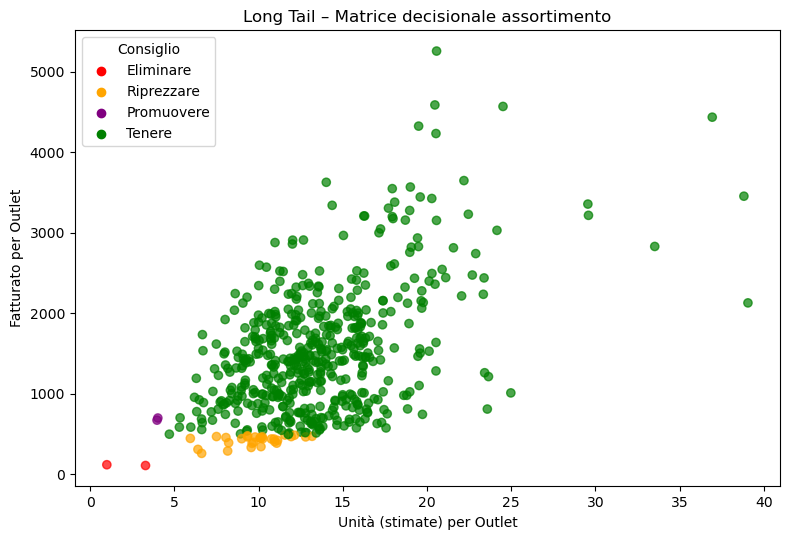

In [130]:
# visualizzazione della matrice decisionale per il quadrante della long tail
# mappa colori decisionale
decision_colors = {
    'Eliminare': 'red',
    'Riprezzare': 'orange',
    'Promuovere': 'purple',
    'Tenere': 'green'}

plt.figure(figsize=(8, 5.5))

plt.scatter(
    long_tail_decision['EUS_per_Outlet'],
    long_tail_decision['Sales_per_Outlet'],
    c=long_tail_decision['Decision'].map(decision_colors),
    alpha=0.7)

plt.xlabel('Unità (stimate) per Outlet')
plt.ylabel('Fatturato per Outlet')
plt.title('Long Tail – Matrice decisionale assortimento')

# legenda
for label, color in decision_colors.items():
    plt.scatter([], [], c=color, label=label)

plt.legend(title='Consiglio')
plt.tight_layout()
plt.show()

In [131]:
# i prodotti in rosso hanno bassi volumi e basso valore => candidati forti alla rimozione
# i prodotti in viola hanno bassi volumi e valore medio => valutare promozioni ed esposizione
# i prodotti in arancione hanno medi volumi e basso valore => prezzo basso, ottimizzare
# i prodotti in verde hanno volumi e valori superiori alla soglia minima => tenere/monitorare

In [132]:
# L’integrazione delle metriche di produttività per punto vendita consente di supportare decisioni di razionalizzazione 
# basate sulla domanda effettiva, distinguendo tra prodotti da eliminare, SKU di nicchia da preservare e 
# articoli che richiedono interventi di prezzo o promozionali 

In [133]:
# voglio visualizzare i prodotti candidati alla eliminazione
eliminate_products = long_tail_decision[long_tail_decision['Decision'] == 'Eliminare'].sort_values(
    by=['Sales_per_Outlet', 'EUS_per_Outlet'],ascending=True)

eliminate_products

,ProductID,NumOutlets,TotalSales,TotalEUS,Sales_per_Outlet,EUS_per_Outlet,Decision
1474,NCR42,3,332.90,9.86,110.966667,3.286667,Eliminare
819,FDQ60,1,120.51,0.99,120.510000,0.990000,Eliminare


## Analisi di Visibilità

In [134]:
# Voglio portare avanti un'analisi del campo ProductVisibility per capire come e se la visibilità influenza le vendite
# L’analisi assume che i prodotti competano per la visibilità esclusivamente all’interno dello stesso punto vendita
# ProductVisibility = quota di esposizione di un prodotto relativa all’assortimento dell’outlet in cui è venduto 

In [135]:
# faccio la somma della visibilità di tutti i prodotti per Outlet
Total_Visibility_outlet=df.groupby("OutletID")["ProductVisibility"].sum()
Total_Visibility_outlet

OutletID
OUT010    56.308832
OUT013    55.879859
OUT017    56.834646
OUT018    56.621454
OUT019    57.257041
OUT027    54.804764
OUT035    56.974873
OUT045    56.180780
OUT046    56.231875
OUT049    56.549156
Name: ProductVisibility, dtype: float64

In [136]:
# Tutti gli outlet hanno una “massa di visibilità” simile
# Le differenze sono compatibili con il numero di righe con ProductVisibility=0 (526 righe)
# La somma della ProductVisibility risulta altamente consistente tra outlet, suggerendo che la metrica sia già espressa 
# in forma relativa. Pertanto, l’analisi viene condotta sui valori originali senza ulteriore normalizzazione

In [137]:
# Focalizzo l'analisi sul cluster: OutletType = "Supermarket Type1" con PriceBand ∈ {Low, Mid-Low}
# Questo per massimizzare la probabilità che la visibilità sia una leva reale (prodotti ad acquisto frequente)
# e non sovrastata da prezzo o tipo di store
# filtro cluster omogeneo
visibility_cluster = df[(df['OutletType'] == 'Supermarket Type1') &(df['PriceBand'].isin(['Low', 'Mid-Low']))].copy()

visibility_cluster.shape

(2769, 16)

### Per l'intero Cluster scelto

In [138]:
# per valutare la performance, utilizziamo le due variabili OutlesSales e EUS
visibility_cluster[['ProductVisibility', 'OutletSales', 'EstimatedUnitsSold']].describe()

,ProductVisibility,OutletSales,EstimatedUnitsSold
count,2769.000000,2769.000000,2769.000000
mean,0.060460,1430.219975,16.169205
std,0.044459,847.990564,7.224799
min,0.000000,73.240000,1.950000
25%,0.026580,769.000000,11.000000
50%,0.048718,1270.350000,15.280000
75%,0.088178,1937.480000,20.750000
max,0.186236,6381.690000,45.290000


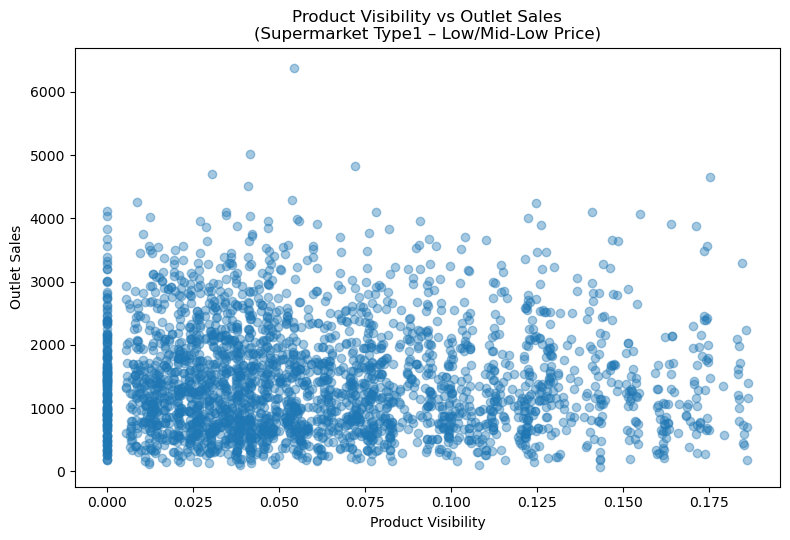

In [139]:
# grafico a dispersione ProductVisibility vs OutletSales
plt.figure(figsize=(8, 5.5))

plt.scatter(
    visibility_cluster['ProductVisibility'],
    visibility_cluster['OutletSales'],
    alpha=0.4)

plt.xlabel('Product Visibility')
plt.ylabel('Outlet Sales')
plt.title('Product Visibility vs Outlet Sales\n(Supermarket Type1 – Low/Mid-Low Price)')

plt.tight_layout()
plt.show()

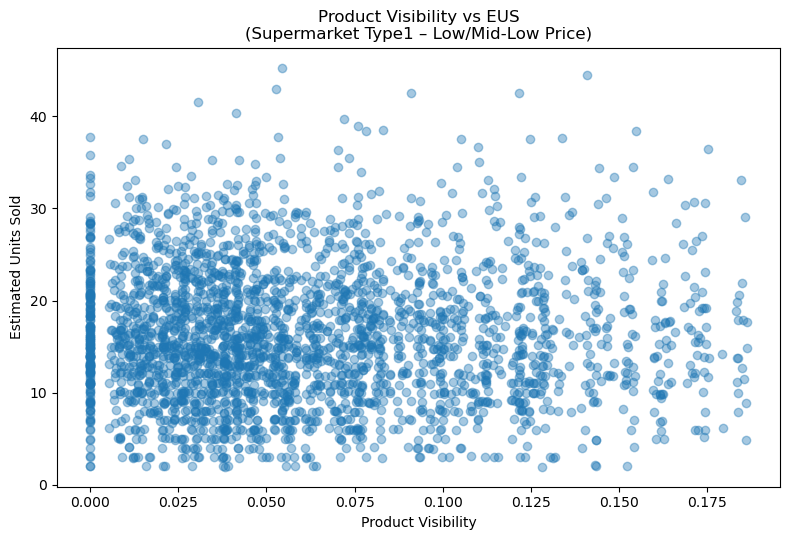

In [140]:
# grafico a dispersione ProductVisibility vs EUS
plt.figure(figsize=(8, 5.5))

plt.scatter(
    visibility_cluster['ProductVisibility'],
    visibility_cluster['EstimatedUnitsSold'],
    alpha=0.4)

plt.xlabel('Product Visibility')
plt.ylabel('Estimated Units Sold')
plt.title('Product Visibility vs EUS\n(Supermarket Type1 – Low/Mid-Low Price)')

plt.tight_layout()
plt.show()

In [141]:
# Il grafico mostra che l'effetto della visibilità non è lineare: l’aumento non sembra produrre benefici significativi
# Dividiamo i dati in 5 bucket (Visibilità=0 e i quattro quartili) per vedere se ci sono variazioni nella media delle vendite
# al passaggio tra i vari bucket

In [142]:
# separo visibility = 0
visibility_zero = visibility_cluster[visibility_cluster['ProductVisibility'] == 0].copy()

visibility_positive = visibility_cluster[visibility_cluster['ProductVisibility'] > 0].copy()

visibility_zero['VisibilityBucket'] = 'Zero Visibility'

In [143]:
# creo quartili di ProductVisibility (>0)
visibility_positive['VisibilityBucket'] = pd.qcut(
    visibility_positive['ProductVisibility'],q=4,labels=['Q1 Low', 'Q2 Mid-Low', 'Q3 Mid-High', 'Q4 High'])

In [144]:
# ricompongo il dataset
visibility_bucketed = pd.concat([visibility_zero, visibility_positive],axis=0)

In [145]:
# confronto tra i 5 bucket
visibility_summary = (visibility_bucketed.groupby('VisibilityBucket').agg(
        Avg_UnitsSold=('EstimatedUnitsSold', 'mean'),
        Avg_Sales=('OutletSales', 'mean'),
        Num_Obs=('ProductVisibility', 'count')).reset_index())

In [146]:
bucket_order = ['Zero Visibility','Q1 Low','Q2 Mid-Low','Q3 Mid-High','Q4 High']

visibility_summary['VisibilityBucket'] = pd.Categorical(visibility_summary['VisibilityBucket'],categories=bucket_order,ordered=True)

visibility_summary = visibility_summary.sort_values('VisibilityBucket')
visibility_summary

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,16.711034,1488.943161,174
0,Q1 Low,16.351464,1446.118706,649
1,Q2 Mid-Low,16.034823,1473.397904,649
2,Q3 Mid-High,16.087454,1397.524660,648
3,Q4 High,16.057689,1388.044284,649


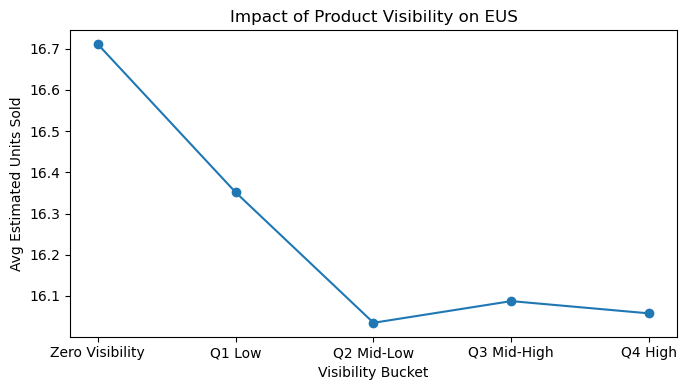

In [147]:
# grafico Product Visibility on EUS
plt.figure(figsize=(7, 4))

plt.plot(
    visibility_summary['VisibilityBucket'],
    visibility_summary['Avg_UnitsSold'],
    marker='o')

plt.xlabel('Visibility Bucket')
plt.ylabel('Avg Estimated Units Sold')
plt.title('Impact of Product Visibility on EUS')

plt.tight_layout()
plt.show()

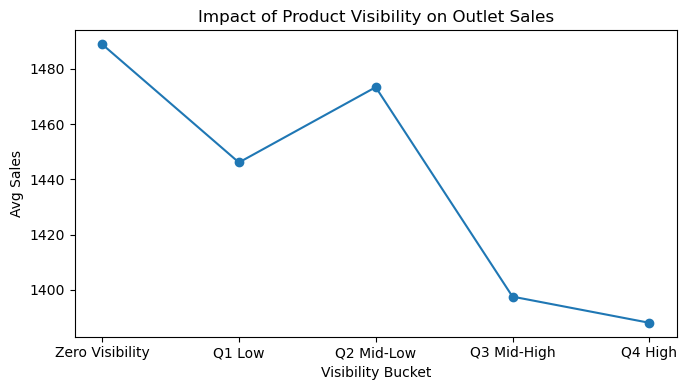

In [148]:
# grafico Product Visibility on Outlet Sales
plt.figure(figsize=(7, 4))

plt.plot(
    visibility_summary['VisibilityBucket'],
    visibility_summary['Avg_Sales'],
    marker='o')

plt.xlabel('Visibility Bucket')
plt.ylabel('Avg Sales')
plt.title('Impact of Product Visibility on Outlet Sales')

plt.tight_layout()
plt.show()

In [149]:
# Nel cluster analizzato (Supermarket Type1, Low/Mid-Low price), la ProductVisibility non mostra un impatto positivo 
# significativo né sulle unità vendute né sul fatturato medio => la visibilità NON è il driver principale della vendita

### Per ProductType del Cluster

In [150]:
# Seleziono tre categorie del Cluster per verificare se la visibilità impatta le vendite almeno in quell'ambito
target_categories = ['Fruits and Vegetables','Snack Foods','Soft Drinks']

In [151]:
# procedo con gli stessi step fatti per l'analisi sull'intero Cluster
def visibility_bucket_analysis(df_cat):

    # separo visibility = 0 e > 0
    vis_zero = df_cat[df_cat['ProductVisibility'] == 0].copy()
    vis_pos = df_cat[df_cat['ProductVisibility'] > 0].copy()

    # bucket quartili sui valori > 0
    vis_pos['VisibilityBucket'] = pd.qcut(vis_pos['ProductVisibility'],
        q=4,labels=['Q1 Low', 'Q2 Mid-Low', 'Q3 Mid-High', 'Q4 High'])

    vis_zero['VisibilityBucket'] = 'Zero Visibility'

    df_bucketed = pd.concat([vis_zero, vis_pos])

    # tabella di sintesi
    summary = (df_bucketed.groupby('VisibilityBucket').agg(
            Avg_UnitsSold=('EstimatedUnitsSold', 'mean'),
            Avg_Sales=('OutletSales', 'mean'),
            Num_Obs=('ProductVisibility', 'count')).reset_index())

    # ordinamento logico
    bucket_order = ['Zero Visibility','Q1 Low','Q2 Mid-Low','Q3 Mid-High','Q4 High']

    summary['VisibilityBucket'] = pd.Categorical(summary['VisibilityBucket'],categories=bucket_order,ordered=True)

    return summary.sort_values('VisibilityBucket')

In [152]:
visibility_results_by_category = {}

for category in target_categories:
    df_cat = visibility_cluster[visibility_cluster['ProductType'] == category].copy()

    visibility_results_by_category[category] = visibility_bucket_analysis(df_cat)

In [153]:
# tabella visibilità per ProductType 'Fruits and Vegetables'
visibility_results_by_category['Fruits and Vegetables']

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,18.794091,1837.819545,22
0,Q1 Low,16.108202,1376.051461,89
1,Q2 Mid-Low,16.436023,1549.036818,88
2,Q3 Mid-High,15.804432,1497.959432,88
3,Q4 High,15.505568,1332.734432,88


In [154]:
# Per Fruits and Vegetables la visibilità sembra non aggiungere valore (categoria ad acquisto routinario, Visibility-Neutral)
# => ottimizzare spazio, non aumentare esposizione

In [155]:
# tabella visibilità per ProductType 'Snack Foods'
visibility_results_by_category['Snack Foods']

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,18.880455,1651.092727,22
0,Q1 Low,17.211685,1625.218202,89
1,Q2 Mid-Low,16.468989,1643.575506,89
2,Q3 Mid-High,16.136023,1480.595682,88
3,Q4 High,15.184045,1507.168989,89


In [156]:
# Per Snack Foods la visibilità sembra non aggiungere valore, anzi se si guarda a EUS c'è una relazione inversa (Visibility-Resistant)
# => ridurre spazio dedicato tramite esposizioni temporanee e/o razionalizzazione dell'assortimento

In [157]:
# tabella visibilità per ProductType 'Soft Drinks'
visibility_results_by_category['Soft Drinks']

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,14.336154,1370.525385,13
0,Q1 Low,16.930294,1304.204412,34
1,Q2 Mid-Low,17.727941,1054.099412,34
2,Q3 Mid-High,15.249091,1281.281212,33
3,Q4 High,17.818529,1339.921471,34


In [158]:
# Per Soft Drinks la visibilità sembra essere una leva reale anche se non lineare (categoria fortemente impulsiva, Visibility-Driven)
# => categoria prioritaria per esposizione

In [159]:
# Da queste analisi abbiamo visto che la visibilità non sembra essere un driver principale alla vendita, ma varia tra
# le categorie: può risultare inefficiente (vedi ProductType "Snack Foods") o può apportare valore (vedi ProductType "Soft Drinks")

In [160]:
# Reputo soddisfacente le analisi fatte e procedo alla definizione dei KPI

# EXECUTIVE KPI SUMMARY

## Portafoglio Prodotti

In [161]:
num_SKU=df["ProductID"].nunique()
print("Numero SKU attivi nel portafoglio:",num_SKU)

Numero SKU attivi nel portafoglio: 1559


In [162]:
fatt_tot=df["OutletSales"].sum()
print("Fatturato totale:", fatt_tot, "(18.59 Milioni)")

Fatturato totale: 18591125.52 (18.59 Milioni)


In [163]:
print(f"Fatturato medio per SKU: {fatt_tot/num_SKU:,.2f}")

Fatturato medio per SKU: 11,925.03


In [164]:
EUS_tot=df["EstimatedUnitsSold"].sum()
print(f"Numero stimato di vendite totali: {EUS_tot:.0f}")

Numero stimato di vendite totali: 131473


In [165]:
print(f"Unità vendute medie per SKU (stimate): {EUS_tot/num_SKU:.2f}")

Unità vendute medie per SKU (stimate): 84.33


## Concentrazione

In [166]:
print(f"L'80% del fatturato è generato dalla top {fatt_pareto_80:.2%} degli SKU")

L'80% del fatturato è generato dalla top 57.73% degli SKU


In [167]:
print(f"L'80% delle vendite stimate è generato dalla top {EUS_pareto_80:.2%} degli SKU")

L'80% delle vendite stimate è generato dalla top 67.42% degli SKU


In [168]:
display(Markdown("### Tabella con performance Fatturato/SKU per Outlet"))
display(outlet_stats_desc)

### Tabella con performance Fatturato/SKU per Outlet

,Fatturato_Outlet,Num_SKU_Outlet,Sales_per_SKU,Productivity_Index
OutletID,,,,
OUT027,3453925.90,935,3694.04,1.82
OUT035,2268122.99,930,2438.84,1.20
OUT049,2183969.83,930,2348.35,1.16
OUT017,2167465.48,926,2340.68,1.15
OUT013,2142663.55,932,2299.00,1.13
OUT046,2118395.22,930,2277.84,1.12
OUT045,2036725.52,929,2192.38,1.08
OUT018,1851822.81,928,1995.50,0.98
OUT010,188340.12,555,339.35,0.17


In [169]:
print("La Produttività SKU per Outlet varia da ~340 a ~3.694")

La Produttività SKU per Outlet varia da ~340 a ~3.694


## Struttura del Portafoglio

In [170]:
display(Markdown("### Panoramica Valore/Volume"))
display(quadrant_summary)

### Panoramica Valore/Volume

,Quadrant,SKU,TotalSales,TotalEUS,%_SKU,%_Sales,%_EUS
0,High Value – High Volume,546,10367236.08,60445.05,35.02,55.76,45.98
1,High Value – Low Volume,234,3293653.71,16499.44,15.01,17.72,12.55
2,Low Value – High Volume,234,1688254.26,23861.97,15.01,9.08,18.15
3,Low Value – Low Volume,545,3241981.47,30666.98,34.96,17.44,23.33


## Assortimento e Distribuzione

In [171]:
print(f"In media, ogni SKU è distribuito in {sku_ubiquity['NumOutlets'].mean().round(2)} outlet")

In media, ogni SKU è distribuito in 5.47 outlet


In [172]:
sku_ubiquity['NumOutlets'].describe()

count    1559.000000
mean        5.466966
std         1.528516
min         1.000000
25%         4.000000
50%         5.000000
75%         6.500000
max        10.000000
Name: NumOutlets, dtype: float64

# KEY INSIGHT & ACTIONS

## Portafoglio ampio con valore concentrato

In [173]:
print("""Il portafoglio conta 1.559 SKU, ma il valore è fortemente concentrato:
57,7% degli SKU genera l’80% del fatturato
67,4% degli SKU genera l’80% dei volumi.

Non siamo in una logica 80/20 estrema ma esiste una coda lunga significativa che contribuisce poco al valore.

Azioni: 
- Ridurre la complessità non performante
- Migliorare efficienza operativa e leggibilità dell’assortimento
- Liberare risorse da riallocare su prodotti core""")

Il portafoglio conta 1.559 SKU, ma il valore è fortemente concentrato:
57,7% degli SKU genera l’80% del fatturato
67,4% degli SKU genera l’80% dei volumi.

Non siamo in una logica 80/20 estrema ma esiste una coda lunga significativa che contribuisce poco al valore.

Azioni: 
- Ridurre la complessità non performante
- Migliorare efficienza operativa e leggibilità dell’assortimento
- Liberare risorse da riallocare su prodotti core


## Matrice Valore/Volume

In [174]:
print("""Guardando la matrice Valore/Volume si nota che:
35% degli SKU (High Value – High Volume) genera: 56% del fatturato, 46% dei volumi
35% degli SKU (Low Value – Low Volume) genera: 17% del fatturato, 23% dei volumi
      
Si evince che la long tail non è irrilevante ma consuma spazio, riduce produttività media e aumenta complessità gestionale.

Azioni:
- KPI e target differenziati per quadrante
- Strategie di pricing, promozione e supporto commerciale non uniformi
- Decisioni guidate dalla reale eterogeneità del portafoglio""")

Guardando la matrice Valore/Volume si nota che:
35% degli SKU (High Value – High Volume) genera: 56% del fatturato, 46% dei volumi
35% degli SKU (Low Value – Low Volume) genera: 17% del fatturato, 23% dei volumi
      
Si evince che la long tail non è irrilevante ma consuma spazio, riduce produttività media e aumenta complessità gestionale.

Azioni:
- KPI e target differenziati per quadrante
- Strategie di pricing, promozione e supporto commerciale non uniformi
- Decisioni guidate dalla reale eterogeneità del portafoglio


## Differenze di produttività tra outlet

In [175]:
print("""La Produttività SKU per outlet varia da ~340 (OUT010, OUT019) a ~3.694 (OUT027).
L'indice di produttività da 0.17 a 1.82

Questi forti differenze non sono spiegabili solamente dal numero degli SKU, 
la produttività dello stesso assortimento varia drasticamente tra outlet.

Azioni:
- Benchmark tra outlet ad alta e bassa produttività
- Replicare le best practice degli outlet performanti su execution e mix di assortimento
- Obiettivi realistici e comparabili per formato""")

La Produttività SKU per outlet varia da ~340 (OUT010, OUT019) a ~3.694 (OUT027).
L'indice di produttività da 0.17 a 1.82

Questi forti differenze non sono spiegabili solamente dal numero degli SKU, 
la produttività dello stesso assortimento varia drasticamente tra outlet.

Azioni:
- Benchmark tra outlet ad alta e bassa produttività
- Replicare le best practice degli outlet performanti su execution e mix di assortimento
- Obiettivi realistici e comparabili per formato


## Star Products VS Long Tail

In [176]:
print("""I top3 Star Products (FDY55,FDA15,FDZ20) hanno un fattore moltiplicativo di 2.3 volte il fatturato mediano 
degli altri prodotti dello stesso quadrante (High Value – High Volume) e un volume maggiore del 52%
Sono i driver principali, con prezzo accettato dal mercato e domanda stabile.

Nel quadrante Low Value – Low Volume ci sono alcuni SKU con performance inferiore al 35% degli altri prodotti dello stesso quadrante 
sui rapporti fatturato/outlet e EUS/outlet (vedi matrice decionale nella sezione Long Tail). 
Sono i candidati principali per operazioni di razionalizzazione, re-pricing e promozione.

Azioni:
- Valutare l'inserimento di FDZ20 negli store di type 2
- Implementare strategie assortitive e di layout specifiche per store per i top Star Products
- Valutare l'eliminazione degli SKU NCR42 e FDQ60 (altamente inefficienti)
- Implementare strategie di re-pricing o promozione per i worst della Long Tail""")

I top3 Star Products (FDY55,FDA15,FDZ20) hanno un fattore moltiplicativo di 2.3 volte il fatturato mediano 
degli altri prodotti dello stesso quadrante (High Value – High Volume) e un volume maggiore del 52%
Sono i driver principali, con prezzo accettato dal mercato e domanda stabile.

Nel quadrante Low Value – Low Volume ci sono alcuni SKU con performance inferiore al 35% degli altri prodotti dello stesso quadrante 
sui rapporti fatturato/outlet e EUS/outlet (vedi matrice decionale nella sezione Long Tail). 
Sono i candidati principali per operazioni di razionalizzazione, re-pricing e promozione.

Azioni:
- Valutare l'inserimento di FDZ20 negli store di type 2
- Implementare strategie assortitive e di layout specifiche per store per i top Star Products
- Valutare l'eliminazione degli SKU NCR42 e FDQ60 (altamente inefficienti)
- Implementare strategie di re-pricing o promozione per i worst della Long Tail


# DATA MODELING & SQLITE

## Creazione del DataBase

In [177]:
# creazione del database con l'obiettivo di avere un modello dati relazionale interrogabile via SQL
os.makedirs("data", exist_ok=True)
conn = sqlite3.connect("data/retail_assortment.db")

# verifica
conn.execute("SELECT 1").fetchall()

[(1,)]

In [178]:
# creazione della tabella fact_sales (ogni riga rappresenta 1 prodotto venduto in 1 outlet)
fact_sales_cols = [
    "ProductID",
    "OutletID",
    "OutletSales",
    "EstimatedUnitsSold",
    "ProductVisibility"]
# la ProductVisibility la inseriamo (anche se non è un driver decisionale primario) per non perdere in futuro la 
# possibilità di fare test sulla visibilità

fact_sales = df[fact_sales_cols]
fact_sales.head(1)

,ProductID,OutletID,OutletSales,EstimatedUnitsSold,ProductVisibility
0,FDA15,OUT049,3735.14,14.95,0.016047


In [179]:
# scrittura nel DB
fact_sales.to_sql(
    "fact_sales",
    conn,
    if_exists="replace",
    index=False)

8523

In [180]:
# creazione delle tabelle dimensionali
cursor = conn.cursor()

# Dimensione prodotto
cursor.execute("""
CREATE TABLE IF NOT EXISTS dim_product (
    ProductID TEXT PRIMARY KEY,
    ProductType TEXT,
    PriceBand TEXT
)
""")

# Dimensione outlet
cursor.execute("""
CREATE TABLE IF NOT EXISTS dim_outlet (
    OutletID TEXT PRIMARY KEY,
    OutletType TEXT,
    OutletSize TEXT
)
""")

conn.commit()

In [181]:
# popolamento della dimensione prodotto e scrittura nel DB
dim_product = (
    df[['ProductID', 'ProductType', 'PriceBand']]
    .drop_duplicates()
)

dim_product.to_sql(
    'dim_product',
    conn,
    if_exists='replace',
    index=False
)

1559

In [182]:
# popolamento della dimensione outlet e scrittura nel DB
dim_outlet = (
    df[['OutletID', 'OutletType', 'OutletSize']]
    .drop_duplicates()
)

dim_outlet.to_sql(
    'dim_outlet',
    conn,
    if_exists='replace',
    index=False
)

10

In [183]:
# verifico che i record caricati coincidano con la lunghezza delle tabelle 
# fact_tables ha 8523 righe come il df originale, dim_product ne ha 1559 come i productID unici e
# dim_outlet ne ha 10 come il numero di outletID unici

## Query di business

In [184]:
# posso procedere con le query SQL
# query che mostra le prime 10 righe di fact_sales (a termini di validazione schema)
query_head10_sales = """
SELECT
    *
FROM fact_sales 
LIMIT 10
"""
pd.read_sql(query_head10_sales, conn)

,ProductID,OutletID,OutletSales,EstimatedUnitsSold,ProductVisibility
0,FDA15,OUT049,3735.14,14.95,0.016047
1,DRC01,OUT018,443.42,9.19,0.019278
2,FDN15,OUT049,2097.27,14.81,0.016760
3,FDX07,OUT010,732.38,4.02,0.000000
4,NCD19,OUT013,994.71,18.47,0.000000
5,FDP36,OUT018,556.61,10.83,0.000000
6,FDO10,OUT013,343.55,5.96,0.012741
7,FDP10,OUT027,4022.76,37.33,0.127470
8,FDH17,OUT045,1076.60,11.10,0.016687
9,FDU28,OUT017,4710.54,25.08,0.094450


In [185]:
# Fatturato per categoria prodotto
query_ft_cat = """
SELECT p.ProductType,
    SUM(f.OutletSales) AS TotalSales
FROM fact_sales f
JOIN dim_product p ON f.ProductID = p.ProductID
GROUP BY p.ProductType
ORDER BY TotalSales DESC
"""
pd.read_sql(query_ft_cat, conn)

,ProductType,TotalSales
0,Fruits and Vegetables,2820059.87
1,Snack Foods,2732786.09
2,Household,2055493.85
3,Frozen Foods,1825734.96
4,Dairy,1522594.03
5,Canned,1444151.53
6,Baking Goods,1265525.36
7,Health and Hygiene,1045200.08
8,Meat,917565.48
9,Soft Drinks,892897.63


In [186]:
# produttività media SKU per outlet
query_prod_SKU_outlet="""
SELECT OutletID, sum(OutletSales) AS TotalSales, COUNT(DISTINCT ProductID) AS Num_SKU, 
    sum(OutletSales)/COUNT(DISTINCT ProductID) AS Sales_per_SKU
FROM fact_sales
GROUP BY OutletID"""
pd.read_sql(query_prod_SKU_outlet,conn)

,OutletID,TotalSales,Num_SKU,Sales_per_SKU
0,OUT010,188340.12,555,339.351568
1,OUT013,2142663.55,932,2298.995225
2,OUT017,2167465.48,926,2340.675464
3,OUT018,1851822.81,928,1995.498718
4,OUT019,179694.10,528,340.329735
5,OUT027,3453925.90,935,3694.038396
6,OUT035,2268122.99,930,2438.841925
7,OUT045,2036725.52,929,2192.384844
8,OUT046,2118395.22,930,2277.844323
9,OUT049,2183969.83,930,2348.354656


In [187]:
# top 10 SKU per fatturato
query_fatt_prod = """
SELECT
    ProductID,
    sum(OutletSales) as FATT_PROD
FROM fact_sales 
GROUP BY ProductID
ORDER BY FATT_PROD DESC
LIMIT 10
"""
pd.read_sql(query_fatt_prod, conn)

,ProductID,FATT_PROD
0,FDY55,42661.81
1,FDA15,41584.54
2,FDZ20,40185.02
3,FDF05,36555.75
4,FDA04,35741.49
5,FDK03,34843.98
6,NCQ06,34680.20
7,NCQ53,34508.41
8,FDJ55,33531.01
9,FDD44,32723.41


In [188]:
# FATTURATO PER OUTLET
query_ft_outlet="""
SELECT o.OutletID,
        sum(f.OutletSales) as FT_TOT
FROM fact_sales f
JOIN dim_outlet o ON o.OutletID=f.OutletID
GROUP BY o.OutletID
ORDER BY FT_TOT DESC
"""
pd.read_sql(query_ft_outlet,conn)

,OutletID,FT_TOT
0,OUT027,3453925.90
1,OUT035,2268122.99
2,OUT049,2183969.83
3,OUT017,2167465.48
4,OUT013,2142663.55
5,OUT046,2118395.22
6,OUT045,2036725.52
7,OUT018,1851822.81
8,OUT010,188340.12
9,OUT019,179694.10


In [189]:
# Fatturato per PriceBand
ft_PriceBand="""
SELECT p.PriceBand, sum(f.OutletSales) AS FT_TOT
FROM fact_sales f
JOIN dim_product p ON p.ProductID=f.ProductID
GROUP BY p.PriceBand
ORDER BY FT_TOT desc"""
pd.read_sql(ft_PriceBand,conn)

,PriceBand,FT_TOT
0,High,7326172.88
1,Mid-High,5536230.15
2,Mid-Low,3703573.34
3,Low,2025149.15


In [190]:
# SKU con fatt < 1000
worst_ft_SKU="""
SELECT ProductID, sum(OutletSales) AS FT_TOT
FROM fact_sales
GROUP BY ProductID
HAVING sum(OutletSales) < 1000
ORDER BY FT_TOT ASC"""
pd.read_sql(worst_ft_SKU,conn)

,ProductID,FT_TOT
0,FDQ60,120.51
1,NCR42,332.90
2,FDY43,673.79
3,FDF38,771.66
4,FDQ04,784.31


In [191]:
# categorie di prodotto con maggior ft medio per SKU
top_cat_ftm_SKU="""
SELECT p.ProductType, sum(f.OutletSales) AS FT_TOT, COUNT(DISTINCT f.ProductID) AS NUM_SKU, 
    sum(f.OutletSales)/COUNT(DISTINCT f.ProductID) AS FT_MEDIOxSKU
FROM fact_sales f
JOIN dim_product p ON f.ProductID=p.ProductID
GROUP BY p.ProductType
ORDER BY FT_MEDIOxSKU desc"""
pd.read_sql(top_cat_ftm_SKU,conn)

,ProductType,FT_TOT,NUM_SKU,FT_MEDIOxSKU
0,Seafood,148868.17,10,14886.817000
1,Fruits and Vegetables,2820059.87,220,12818.453955
2,Snack Foods,2732786.09,220,12421.754955
3,Breads,553237.21,45,12294.160222
4,Dairy,1522594.03,125,12180.752240
5,Household,2055493.85,170,12091.140294
6,Canned,1444151.53,120,12034.596083
7,Frozen Foods,1825734.96,155,11778.935226
8,Starchy Foods,351401.26,30,11713.375333
9,Breakfast,232298.98,20,11614.949000


# DASHBOARD (TABLEAU PUBLIC)

In [192]:
# per operare con Tableau Public ho bisogno di importare le tabelle in file supportati, come ad esempio .csv
# Recupero i nomi di tutte le tabelle nel database
tabelle = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

In [193]:
tabelle

,name
0,fact_sales
1,dim_product
2,dim_outlet


In [194]:
for nome_tabella in tabelle['name']:
    df = pd.read_sql_query(f"SELECT * FROM {nome_tabella}", conn)
    df.to_csv(f"{nome_tabella}.csv", index=False)
    print(f"Esportata tabella: {nome_tabella}")

Esportata tabella: fact_sales
Esportata tabella: dim_product
Esportata tabella: dim_outlet
